In [182]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

In [183]:
def Rastrigin(A,x):
    return A* x.ndim  + sum([(xi**2 + A * torch.cos(2*torch.pi *xi)) for xi in x])

In [184]:
#SGD

p = torch.tensor([[5.0],[5.0]], requires_grad=True)
A = 1

iteration = 100
sgd_model = torch.optim.SGD([p],lr=0.01)
loss_data_1 = []
path_1 = np.empty((2,0))

for i in range(iteration):
    sgd_model.zero_grad()
    output = Rastrigin(A, p)
    output.backward()
    sgd_model.step()
    path_1 = np.append(path_1, p.data.numpy(), axis=1)
    loss = output.item()
    loss_data_1.append(loss)

In [185]:
# momentum

p = torch.tensor([[5.0],[5.0]],requires_grad=True)
A = 1

iteration = 100
sgd_model = torch.optim.SGD([p],lr=0.01,momentum=0.9)
loss_data_2 = []
path_2 = np.empty((2,0))

for i in range(iteration):
    sgd_model.zero_grad()
    output = Rastrigin(A,p)
    output.backward()
    sgd_model.step()
    loss = output.item()
    loss_data_2.append(loss)
    path_2 = np.append(path_2, p.data.numpy(), axis=1)

In [186]:
# adagrad

p = torch.tensor([[5.0],[5.0]],requires_grad=True)
A = 1

iteration = 100
sgd_model = torch.optim.Adagrad([p],lr=0.01)
loss_data_3 = []
path_3 = np.empty((2,0))

for i in range(iteration):
    sgd_model.zero_grad()
    output = Rastrigin(A,p)
    output.backward()
    sgd_model.step()
    loss = output.item()
    loss_data_3.append(loss)
    path_3 = np.append(path_3, p.data.numpy(), axis=1)


In [187]:
# adam

p = torch.tensor([[5.0],[5.0]],requires_grad=True)
A = 1

iteration = 100
sgd_model = torch.optim.Adam([p],lr=0.01)
loss_data_4 = []
path_4 = np.empty((2,0))

for i in range(iteration):
    sgd_model.zero_grad()
    output = Rastrigin(A,p)
    output.backward()
    path_4 = np.append(path_4, p.data.numpy(), axis=1)
    sgd_model.step()
    loss = output.item()
    loss_data_4.append(loss)

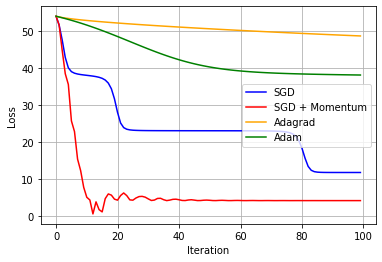

In [268]:
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(loss_data_1, color = "b",label="SGD")
ax.plot(loss_data_2, color = "r",label="SGD + Momentum")
ax.plot(loss_data_3, color = "orange",label="Adagrad")
ax.plot(loss_data_4, color = "green",label="Adam")
ax.grid(True)
plt.ylabel("Loss")
plt.xlabel("Iteration")
ax.legend()

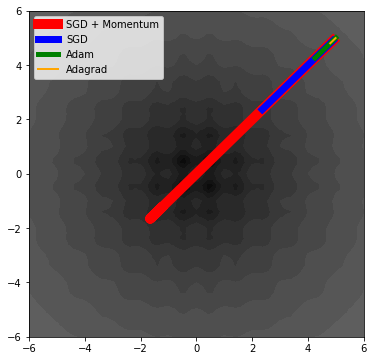

In [264]:
xmin, xmax, xstep = -6, 6, .2
ymin, ymax, ystep = -6, 6, .2
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = Rastrigin(A,torch.tensor([x, y])).numpy()

fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.gray)

plt.plot(path_2[0],path_2[1], color = "red",label="SGD + Momentum",linewidth=10)
plt.plot(path_1[0],path_1[1], color = "blue",label="SGD",linewidth=7)
plt.plot(path_4[0],path_4[1], color = "green",label="Adam",linewidth=5)
plt.plot(path_3[0],path_3[1], color = "orange",label="Adagrad",linewidth=2)
plt.legend()

In [1]:
import pandas as pd
import torch
from typing import Tuple
from matplotlib import pyplot as plt
import numpy as np
from numpy.ma.core import zeros
from torch.utils import data
import torch.optim as optim

In [2]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df = df.sample(frac=1,random_state =0)
df = df[df[4].isin(["Iris-virginica","Iris-versicolor"])]
mapping = {k: v for v,k in enumerate(df[4].unique())}
df[5] = (2* df[4].map(mapping))-1
alldata = torch.tensor(df.iloc[:,[0,1,2,3]].values, dtype= torch.float)
alldata = (alldata - alldata.mean(dim=0))/alldata.var(dim=0)

targets_tr = torch.tensor(df.iloc[:75, 5].values,dtype=torch.long)
targets_va = torch.tensor(df.iloc[75:, 5].values,dtype=torch.long)
data_tr = alldata[:75]
data_va = alldata[75:]

In [3]:
def accuracy(prediction,target):
    score = 0
    for i in range(prediction.shape[0]):
        if (prediction[i] >= 0.5 and target[i]==1) or (prediction[i] < 0.5 and target[i]==-1):
            score+=1
    accuracy = score / prediction.shape[0]
    return accuracy

def hinge_loss(y_pred, y_true):
    # YOUR CODE HERE
    yz = y_pred * y_true
    return torch.max(torch.zeros_like(yz), 1-yz).mean()

def svm(x, w, b):
    h = (w*x).sum(1) + b
    return h

In [4]:
# load data 
dataset = data.TensorDataset(data_tr,targets_tr) # create your datset
dataloader = data.DataLoader(dataset, batch_size=25, shuffle=True) # create your dataloader

In [5]:
acc = []
for i in range(100):
    # load data 
    dataset = data.TensorDataset(data_tr,targets_tr) # create your datset
    dataloader = data.DataLoader(dataset, batch_size=25, shuffle=True) # create your dataloader

    w = torch.randn(1, 4, requires_grad=True)
    b = torch.randn(1, requires_grad=True)

    opt_sgd = optim.SGD([w,b], lr=0.01, weight_decay=0.0001)
    epochs = 100

    loss_sgd = []

    for epoch in range(epochs):
        # 此时是batch gradient， 将opt_sgd.zero_grad()放入下面的循环时就是 sgd，不将梯度归0的话梯度再每次backward会积累
        opt_sgd.zero_grad()
        for batch in dataloader:
            output = svm(batch[0], w, b)
            loss = hinge_loss(output,batch[1])
            loss.backward()
            opt_sgd.step()
            print(w.grad)
        output = svm(batch[0], w, b)
        print(w.grad)
        loss_sgd.append(hinge_loss(output,batch[1]).data)
        print("~~~~~~~~~~~")

    prediction_va =  torch.sigmoid(svm(data_va, w, b))
    accuracy_sgd = accuracy(prediction_va,targets_va)
#     print("SGD validation set accuracy: ",accuracy_sgd)
    acc.append(accuracy_sgd)
#     print(accuracy_sgd)

print(sum(acc)/len(acc))

tensor([[0.5861, 0.1546, 0.7039, 1.6237]])
tensor([[0.9459, 0.2312, 1.3304, 3.2412]])
tensor([[1.3873, 0.3714, 2.1417, 4.7496]])
tensor([[1.3873, 0.3714, 2.1417, 4.7496]])
~~~~~~~~~~~
tensor([[ 0.3984, -0.2327,  0.6155,  1.4295]])
tensor([[0.7817, 0.1503, 1.3567, 3.5312]])
tensor([[ 1.3019, -0.0723,  2.0482,  4.4561]])
tensor([[ 1.3019, -0.0723,  2.0482,  4.4561]])
~~~~~~~~~~~
tensor([[ 0.5940, -0.0925,  0.7167,  1.4747]])
tensor([[ 0.7375, -0.1445,  1.3263,  2.8155]])
tensor([[ 1.1177, -0.4494,  1.8890,  4.1785]])
tensor([[ 1.1177, -0.4494,  1.8890,  4.1785]])
~~~~~~~~~~~
tensor([[0.5497, 0.4436, 0.7919, 1.8010]])
tensor([[1.1563, 0.4335, 1.4613, 3.1924]])
tensor([[ 1.1177, -0.4494,  1.8890,  4.1785]])
tensor([[ 1.1177, -0.4494,  1.8890,  4.1785]])
~~~~~~~~~~~
tensor([[ 0.3390, -0.4899,  0.6932,  1.6521]])
tensor([[ 0.6602, -0.6459,  1.3132,  2.8590]])
tensor([[ 1.1177, -0.4494,  1.8890,  4.1785]])
tensor([[ 1.1177, -0.4494,  1.8890,  4.1785]])
~~~~~~~~~~~
tensor([[ 0.3356, -0.1749,  

tensor([[2.1599, 4.3510, 2.1310, 4.3346]])
tensor([[2.1599, 4.3510, 2.1310, 4.3346]])
~~~~~~~~~~~
tensor([[0.5237, 0.9797, 0.6207, 1.2184]])
tensor([[1.5252, 2.8222, 1.4834, 2.8146]])
tensor([[2.1725, 4.3611, 2.0955, 4.2512]])
tensor([[2.1725, 4.3611, 2.0955, 4.2512]])
~~~~~~~~~~~
tensor([[0.5940, 1.4248, 0.6111, 1.2752]])
tensor([[1.3236, 2.8641, 1.2908, 2.7322]])
tensor([[2.0143, 4.2788, 1.9374, 3.9134]])
tensor([[2.0143, 4.2788, 1.9374, 3.9134]])
~~~~~~~~~~~
tensor([[0.3321, 0.6821, 0.3711, 0.7990]])
tensor([[1.2495, 2.5086, 1.2214, 2.4502]])
tensor([[1.9197, 4.2687, 1.8556, 3.8859]])
tensor([[1.9197, 4.2687, 1.8556, 3.8859]])
~~~~~~~~~~~
tensor([[0.5918, 1.9147, 0.6280, 1.3523]])
tensor([[1.2586, 3.0144, 1.2097, 2.3172]])
tensor([[1.6830, 4.1964, 1.6443, 3.5312]])
tensor([[1.6830, 4.1964, 1.6443, 3.5312]])
~~~~~~~~~~~
tensor([[0.5767, 1.2659, 0.4720, 1.0934]])
tensor([[0.9066, 2.5100, 0.8835, 1.9917]])
tensor([[1.5395, 4.1039, 1.5276, 3.3653]])
tensor([[1.5395, 4.1039, 1.5276, 3.36

tensor([[-0.1795,  0.4220,  0.1857,  0.2758]])
tensor([[-0.2103,  0.8454,  0.2389,  0.6030]])
tensor([[-0.2103,  0.8454,  0.2389,  0.6030]])
~~~~~~~~~~~
tensor([[-0.1227,  0.4017,  0.1042,  0.2430]])
tensor([[-0.0430,  0.7110,  0.1739,  0.3866]])
tensor([[-0.2342,  0.6026,  0.1857,  0.4531]])
tensor([[-0.2342,  0.6026,  0.1857,  0.4531]])
~~~~~~~~~~~
tensor([[-0.0772,  0.1850,  0.0397,  0.1986]])
tensor([[-0.0828,  0.5202,  0.1097,  0.2926]])
tensor([[-0.2558,  0.4841,  0.1743,  0.3813]])
tensor([[-0.2558,  0.4841,  0.1743,  0.3813]])
~~~~~~~~~~~
tensor([[-0.0980,  0.0520, -0.0052,  0.1445]])
tensor([[-0.3187,  0.2529,  0.0822,  0.3769]])
tensor([[-0.3139,  0.4017,  0.1747,  0.4203]])
tensor([[-0.3139,  0.4017,  0.1747,  0.4203]])
~~~~~~~~~~~
tensor([[-0.0273,  0.0723,  0.0411,  0.0887]])
tensor([[-0.1171,  0.5722,  0.1515,  0.3485]])
tensor([[-0.3139,  0.4017,  0.1747,  0.4203]])
tensor([[-0.3139,  0.4017,  0.1747,  0.4203]])
~~~~~~~~~~~
tensor([[ 0.0035, -0.0260,  0.0114, -0.0390]])


tensor([[-0.2232, -0.2572,  0.1657,  0.3778]])
tensor([[-0.3156, -0.1792,  0.2783,  0.4948]])
tensor([[-0.3156, -0.1792,  0.2783,  0.4948]])
~~~~~~~~~~~
tensor([[-0.0810, -0.0506,  0.1543,  0.3281]])
tensor([[-0.2323, -0.2933,  0.2244,  0.3556]])
tensor([[-0.3156, -0.1792,  0.2783,  0.4948]])
tensor([[-0.3156, -0.1792,  0.2783,  0.4948]])
~~~~~~~~~~~
tensor([[-0.0615, -0.0564,  0.1005,  0.0559]])
tensor([[-0.0901, -0.0506,  0.2189,  0.2838]])
tensor([[-0.3156, -0.1792,  0.2783,  0.4948]])
tensor([[-0.3156, -0.1792,  0.2783,  0.4948]])
~~~~~~~~~~~
tensor([[0.0716, 0.4393, 0.1478, 0.2279]])
tensor([[-0.1001,  0.2529,  0.1761,  0.1995]])
tensor([[-0.3156, -0.1792,  0.2783,  0.4948]])
tensor([[-0.3156, -0.1792,  0.2783,  0.4948]])
~~~~~~~~~~~
tensor([[-0.1708, -0.0564,  0.0300,  0.1889]])
tensor([[-0.2848, -0.3136,  0.1254,  0.3450]])
tensor([[-0.3849, -0.3858,  0.2251,  0.4115]])
tensor([[-0.3849, -0.3858,  0.2251,  0.4115]])
~~~~~~~~~~~
tensor([[-0.0910,  0.2890,  0.0998,  0.1330]])
tens

tensor([[-0.0091,  0.2890,  0.0235,  0.0665]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
~~~~~~~~~~~
tensor([[-0.0625, -0.0780,  0.0928, -0.0727]])
tensor([[-0.1626, -0.1503,  0.0576, -0.0505]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
~~~~~~~~~~~
tensor([[-0.0239, -0.0260,  0.0231,  0.0275]])
tensor([[-0.0590,  0.0043,  0.0749, -0.0009]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
~~~~~~~~~~~
tensor([[-0.0091,  0.2890,  0.0235,  0.0665]])
tensor([[-0.1353,  0.1026,  0.0048,  0.0603]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
~~~~~~~~~~~
tensor([[-0.1479, -0.3772, -0.0183, -0.0337]])
tensor([[-0.1479, -0.1243,  0.0345, -0.0115]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
~~~~~~~~~~~
tensor([[-0.0330,  0.2991,  0.0642,  0.0497]])


tensor([[-0.2983,  0.0159,  0.1122,  0.2332]])
tensor([[-0.2983,  0.0159,  0.1122,  0.2332]])
~~~~~~~~~~~
tensor([[-0.0342, -0.0202, -0.0110,  0.0559]])
tensor([[-0.2584,  0.0983,  0.1001,  0.1942]])
tensor([[-0.2983,  0.0159,  0.1122,  0.2332]])
tensor([[-0.2983,  0.0159,  0.1122,  0.2332]])
~~~~~~~~~~~
tensor([[-0.2549, -0.3974,  0.0587,  0.0222]])
tensor([[-0.2402, -0.1185,  0.1060,  0.1277]])
tensor([[-0.2983,  0.0159,  0.1122,  0.2332]])
tensor([[-0.2983,  0.0159,  0.1122,  0.2332]])
~~~~~~~~~~~
tensor([[-0.0615,  0.2688,  0.0594,  0.1002]])
tensor([[-0.0763,  0.3150,  0.1236,  0.1499]])
tensor([[-0.2983,  0.0159,  0.1122,  0.2332]])
tensor([[-0.2983,  0.0159,  0.1122,  0.2332]])
~~~~~~~~~~~
tensor([[-0.1014,  0.0058,  0.0597,  0.2057]])
tensor([[-0.2744,  0.0058,  0.0715,  0.2501]])
tensor([[-0.2983,  0.0159,  0.1122,  0.2332]])
tensor([[-0.2983,  0.0159,  0.1122,  0.2332]])
~~~~~~~~~~~
tensor([[-0.1981, -0.3092,  0.0124,  0.1224]])
tensor([[-0.2254, -0.1647,  0.1063,  0.1002]])


tensor([[-0.3152, -0.7847,  0.0994,  0.4265]])
tensor([[-0.0863, -0.7543,  0.4622,  0.7085]])
tensor([[-0.0929, -1.2716,  0.7477,  1.0287]])
tensor([[-0.0929, -1.2716,  0.7477,  1.0287]])
~~~~~~~~~~~
tensor([[ 0.1014, -0.3670,  0.3041,  0.4372]])
tensor([[-0.0612, -1.2037,  0.5613,  0.7635]])
tensor([[-0.1748, -1.1633,  0.6949,  1.0287]])
tensor([[-0.1748, -1.1633,  0.6949,  1.0287]])
~~~~~~~~~~~
tensor([[-0.3573, -0.7384,  0.1460,  0.3654]])
tensor([[-0.1843, -1.0274,  0.3338,  0.5205]])
tensor([[-0.1874, -1.1373,  0.6541,  0.9347]])
tensor([[-0.1874, -1.1373,  0.6541,  0.9347]])
~~~~~~~~~~~
tensor([[-0.0477, -0.4855,  0.2399,  0.3654]])
tensor([[-0.1704, -1.2398,  0.5085,  0.7192]])
tensor([[-0.1874, -1.1373,  0.6541,  0.9347]])
tensor([[-0.1874, -1.1373,  0.6541,  0.9347]])
~~~~~~~~~~~
tensor([[-0.1479,  0.0202,  0.1754,  0.2323]])
tensor([[-0.1431, -0.4451,  0.4204,  0.5640]])
tensor([[-0.1258, -0.5751,  0.6241,  0.8788]])
tensor([[-0.1258, -0.5751,  0.6241,  0.8788]])
~~~~~~~~~~~


tensor([[ 0.3281, -1.2557,  0.4491,  0.2643]])
~~~~~~~~~~~
tensor([[ 0.1218, -0.3511,  0.1229,  0.1383]])
tensor([[ 0.1266, -0.8887,  0.2389,  0.1596]])
tensor([[ 0.3281, -1.2557,  0.4491,  0.2643]])
tensor([[ 0.3281, -1.2557,  0.4491,  0.2643]])
~~~~~~~~~~~
tensor([[ 0.0035, -0.4957,  0.0818, -0.0390]])
tensor([[ 0.2597, -0.9349,  0.3038,  0.0656]])
tensor([[ 0.3281, -1.2557,  0.4491,  0.2643]])
tensor([[ 0.3281, -1.2557,  0.4491,  0.2643]])
~~~~~~~~~~~
tensor([[ 0.0945, -0.4957,  0.1698,  0.0275]])
tensor([[ 0.1868, -0.8627,  0.2979,  0.1765]])
tensor([[ 0.3281, -1.2557,  0.4491,  0.2643]])
tensor([[ 0.3281, -1.2557,  0.4491,  0.2643]])
~~~~~~~~~~~
tensor([[ 0.0819, -0.0361,  0.0763,  0.0443]])
tensor([[ 0.2393, -0.9147,  0.3031,  0.1428]])
tensor([[ 0.3407, -1.1373,  0.4252,  0.2252]])
tensor([[ 0.3407, -1.1373,  0.4252,  0.2252]])
~~~~~~~~~~~
tensor([[ 0.1014, -0.2225,  0.1750, -0.0062]])
tensor([[ 0.3030, -0.7702,  0.3500,  0.0541]])
tensor([[ 0.3407, -1.1373,  0.4252,  0.2252]])


tensor([[-0.0747, -0.4046,  0.0962,  0.0975]])
tensor([[-0.0747, -0.4046,  0.0962,  0.0975]])
~~~~~~~~~~~
tensor([[-0.1205, -0.1965, -0.0242,  0.0328]])
tensor([[-0.1522, -0.6980,  0.0390, -0.0568]])
tensor([[-0.0747, -0.4046,  0.0962,  0.0975]])
tensor([[-0.0747, -0.4046,  0.0962,  0.0975]])
~~~~~~~~~~~
tensor([[-0.0295, -0.2688,  0.0110,  0.0550]])
tensor([[-0.1522, -0.4089,  0.0331,  0.0984]])
tensor([[-0.0747, -0.4046,  0.0962,  0.0975]])
tensor([[-0.0747, -0.4046,  0.0962,  0.0975]])
~~~~~~~~~~~
tensor([[ 0.0229,  0.0405,  0.1042, -0.0231]])
tensor([[-0.1020, -0.3324,  0.1021,  0.0310]])
tensor([[-0.0747, -0.4046,  0.0962,  0.0975]])
tensor([[-0.0747, -0.4046,  0.0962,  0.0975]])
~~~~~~~~~~~
tensor([[-0.1808, -0.3309, -0.0069, -0.0062]])
tensor([[-0.1830, -0.3829, -0.0018, -0.0177]])
tensor([[-0.0781, -0.2702,  0.0907,  0.0479]])
tensor([[-0.0781, -0.2702,  0.0907,  0.0479]])
~~~~~~~~~~~
tensor([[-0.0135, -0.2847,  0.0573, -0.0009]])
tensor([[ 0.0788, -0.1821,  0.1032,  0.0151]])


tensor([[-0.0412, -0.0043,  0.0190,  0.1561]])
tensor([[-0.2211,  0.0477,  0.0843,  0.4115]])
tensor([[-0.4578, -0.2052,  0.1019,  0.5667]])
tensor([[-0.4578, -0.2052,  0.1019,  0.5667]])
~~~~~~~~~~~
tensor([[-0.2527,  0.2327,  0.0359,  0.2554]])
tensor([[-0.3199,  0.1142,  0.0480,  0.3166]])
tensor([[-0.4578, -0.2052,  0.1019,  0.5667]])
tensor([[-0.4578, -0.2052,  0.1019,  0.5667]])
~~~~~~~~~~~
tensor([[-0.0217,  0.2428,  0.0356,  0.1277]])
tensor([[-0.0776,  0.2847,  0.0718,  0.2891]])
tensor([[-0.4578, -0.2052,  0.1019,  0.5667]])
tensor([[-0.4578, -0.2052,  0.1019,  0.5667]])
~~~~~~~~~~~
tensor([[-0.0980,  0.0520,  0.0124,  0.1667]])
tensor([[-0.3724, -0.2312,  0.0428,  0.4390]])
tensor([[-0.4578, -0.2052,  0.1019,  0.5667]])
tensor([[-0.4578, -0.2052,  0.1019,  0.5667]])
~~~~~~~~~~~
tensor([[-0.2323, -0.1127,  0.0249,  0.2891]])
tensor([[-0.2791, -0.0347,  0.1140,  0.4948]])
tensor([[-0.4578, -0.2052,  0.1019,  0.5667]])
tensor([[-0.4578, -0.2052,  0.1019,  0.5667]])
~~~~~~~~~~~


tensor([[-0.1865,  0.0766,  0.0455,  0.0656]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
~~~~~~~~~~~
tensor([[-0.1353, -0.0780, -0.0187,  0.0381]])
tensor([[-0.1591,  0.1127,  0.0455,  0.0435]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
~~~~~~~~~~~
tensor([[-0.1001,  0.1445, -0.0176,  0.0887]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
tensor([[-0.1830, -0.1301,  0.0511,  0.0044]])
~~~~~~~~~~~
tensor([[-0.0534, -0.0780,  0.0459, -0.0062]])
tensor([[-0.0499, -0.1040,  0.0573, -0.0452]])
tensor([[-0.1591,  0.1127,  0.0455,  0.0435]])
tensor([[-0.1591,  0.1127,  0.0455,  0.0435]])
~~~~~~~~~~~
tensor([[-0.1570, -0.0881, -0.0124,  0.0328]])
tensor([[-0.1479, -0.1243,  0.0169, -0.0115]])
tensor([[-0.1591,  0.1127,  0.0455,  0.0435]])
tensor([[-0.1591,  0.1127,  0.0455,  0.0435]])
~~~~~~~~~~~
tensor([[-0.0169, -0.0058,  0.0048,  0.0160]])


tensor([[ 0.1551, -0.0275,  0.3728,  0.5081]])
tensor([[ 0.2318, -0.0087,  0.5633,  1.0659]])
tensor([[ 0.0887, -0.9595,  0.8546,  1.8516]])
tensor([[ 0.0887, -0.9595,  0.8546,  1.8516]])
~~~~~~~~~~~
tensor([[ 0.0641, -0.0275,  0.3141,  0.6633]])
tensor([[ 0.1338, -0.7514,  0.6285,  1.2105]])
tensor([[ 0.0943, -1.1503,  0.8256,  1.7133]])
tensor([[ 0.0943, -1.1503,  0.8256,  1.7133]])
~~~~~~~~~~~
tensor([[ 0.0801, -0.3685,  0.2606,  0.6961]])
tensor([[-0.0049, -0.6589,  0.4870,  1.1102]])
tensor([[ 0.1251, -1.1040,  0.7959,  1.6521]])
tensor([[ 0.1251, -1.1040,  0.7959,  1.6521]])
~~~~~~~~~~~
tensor([[ 0.2700, -0.6517,  0.3614,  0.4806]])
tensor([[ 0.2362, -0.7717,  0.5823,  1.0668]])
tensor([[ 0.0670, -1.1864,  0.7845,  1.5137]])
tensor([[ 0.0670, -1.1864,  0.7845,  1.5137]])
~~~~~~~~~~~
tensor([[ 0.0779, -0.0592,  0.2833,  0.4407]])
tensor([[ 0.1225, -0.4422,  0.5222,  0.9551]])
tensor([[ 0.0670, -1.1864,  0.7845,  1.5137]])
tensor([[ 0.0670, -1.1864,  0.7845,  1.5137]])
~~~~~~~~~~~


tensor([[-0.0056,  0.1546,  0.0407,  0.0718]])
tensor([[-0.0191,  0.3757,  0.1215,  0.1818]])
tensor([[-0.0599, -0.0173,  0.1729,  0.0701]])
tensor([[-0.0599, -0.0173,  0.1729,  0.0701]])
~~~~~~~~~~~
tensor([[ 0.0126,  0.0462, -0.0121,  0.0718]])
tensor([[0.0503, 0.1488, 0.0690, 0.0878]])
tensor([[-0.0599, -0.0173,  0.1729,  0.0701]])
tensor([[-0.0599, -0.0173,  0.1729,  0.0701]])
~~~~~~~~~~~
tensor([[-0.0022,  0.0564,  0.0521,  0.0328]])
tensor([[-0.0521, -0.0838,  0.1153,  0.0541]])
tensor([[-0.0599, -0.0173,  0.1729,  0.0701]])
tensor([[-0.0599, -0.0173,  0.1729,  0.0701]])
~~~~~~~~~~~
tensor([[-0.0351,  0.1026,  0.0635,  0.0603]])
tensor([[-0.0668, -0.0376,  0.0973,  0.0816]])
tensor([[-0.0599, -0.0173,  0.1729,  0.0701]])
tensor([[-0.0599, -0.0173,  0.1729,  0.0701]])
~~~~~~~~~~~
tensor([[ 0.0776,  0.0405,  0.1277, -0.0231]])
tensor([[-0.0408, -0.0318,  0.1218, -0.0009]])
tensor([[-0.0599, -0.0173,  0.1729,  0.0701]])
tensor([[-0.0599, -0.0173,  0.1729,  0.0701]])
~~~~~~~~~~~
tens

tensor([[-0.1752, -0.2688,  0.1401,  0.0550]])
~~~~~~~~~~~
tensor([[-0.1001, -0.0723, -0.0352,  0.0222]])
tensor([[-0.1366, -0.0723,  0.1350,  0.0665]])
tensor([[-0.1752, -0.2688,  0.1401,  0.0550]])
tensor([[-0.1752, -0.2688,  0.1401,  0.0550]])
~~~~~~~~~~~
tensor([[-0.0728, -0.0361,  0.0411,  0.1108]])
tensor([[0.0399, 0.0462, 0.0935, 0.0718]])
tensor([[-0.1171, -0.1864,  0.1398,  0.0160]])
tensor([[-0.1171, -0.1864,  0.1398,  0.0160]])
~~~~~~~~~~~
tensor([[0.0694, 0.0260, 0.0708, 0.0834]])
tensor([[0.0694, 0.0260, 0.0708, 0.0834]])
tensor([[-0.1171, -0.1864,  0.1398,  0.0160]])
tensor([[-0.1171, -0.1864,  0.1398,  0.0160]])
~~~~~~~~~~~
tensor([[-0.1591, -0.5014,  0.0338, -0.1339]])
tensor([[-0.1661, -0.3049,  0.0697, -0.0337]])
tensor([[-0.1171, -0.1864,  0.1398,  0.0160]])
tensor([[-0.1171, -0.1864,  0.1398,  0.0160]])
~~~~~~~~~~~
tensor([[-0.1422, -0.3150, -0.0004, -0.0168]])
tensor([[-0.1570, -0.4133,  0.0404, -0.0780]])
tensor([[-0.1136, -0.0318,  0.1277, -0.0009]])
tensor([[-0.

tensor([[-0.2983, -0.1286,  0.0300,  0.3441]])
tensor([[-0.3312, -0.2269,  0.1001,  0.2829]])
tensor([[-0.4803, -0.1647,  0.1298,  0.3884]])
tensor([[-0.4803, -0.1647,  0.1298,  0.3884]])
~~~~~~~~~~~
tensor([[-0.0260, -0.0780,  0.0518, -0.0727]])
tensor([[-0.2003,  0.2168,  0.1115,  0.2217]])
tensor([[-0.4803, -0.1647,  0.1298,  0.3884]])
tensor([[-0.4803, -0.1647,  0.1298,  0.3884]])
~~~~~~~~~~~
tensor([[-0.2389, -0.0159,  0.0697,  0.1437]])
tensor([[-0.4461, -0.1445,  0.0998,  0.3325]])
tensor([[-0.4803, -0.1647,  0.1298,  0.3884]])
tensor([[-0.4803, -0.1647,  0.1298,  0.3884]])
~~~~~~~~~~~
tensor([[-0.0615,  0.1243,  0.1122,  0.0780]])
tensor([[-0.3004, -0.0361,  0.1115,  0.1995]])
tensor([[-0.4803, -0.1647,  0.1298,  0.3884]])
tensor([[-0.4803, -0.1647,  0.1298,  0.3884]])
~~~~~~~~~~~
tensor([[-0.1513, -0.2789,  0.0877,  0.0275]])
tensor([[-0.2003, -0.2529,  0.0763,  0.1108]])
tensor([[-0.4496, -0.1185,  0.1001,  0.3272]])
tensor([[-0.4496, -0.1185,  0.1001,  0.3272]])
~~~~~~~~~~~


tensor([[ 0.0412, -0.5737,  0.1747, -0.0452]])
tensor([[ 0.0412, -0.5737,  0.1747, -0.0452]])
~~~~~~~~~~~
tensor([[0.1947, 0.2269, 0.1053, 0.0275]])
tensor([[0.1764, 0.2269, 0.1346, 0.0275]])
tensor([[ 0.1504,  0.1488,  0.1864, -0.0452]])
tensor([[ 0.1504,  0.1488,  0.1864, -0.0452]])
~~~~~~~~~~~
tensor([[0.0672, 0.0101, 0.0759, 0.0718]])
tensor([[ 0.0559, -0.1142,  0.1281, -0.0284]])
tensor([[ 0.0173, -0.3829,  0.1508, -0.0621]])
tensor([[ 0.0173, -0.3829,  0.1508, -0.0621]])
~~~~~~~~~~~
tensor([[ 0.0126,  0.0824, -0.0004,  0.0053]])
tensor([[-0.0408, -0.0318,  0.0808, -0.0231]])
tensor([[ 0.0264,  0.0145,  0.1626, -0.0399]])
tensor([[ 0.0264,  0.0145,  0.1626, -0.0399]])
~~~~~~~~~~~
tensor([[0., 0., 0., 0.]])
tensor([[ 0.0594, -0.0318,  0.1042, -0.0896]])
tensor([[ 0.0264,  0.0145,  0.1626, -0.0399]])
tensor([[ 0.0264,  0.0145,  0.1626, -0.0399]])
~~~~~~~~~~~
tensor([[0., 0., 0., 0.]])
tensor([[0.0945, 0.2269, 0.0525, 0.0718]])
tensor([[ 0.0264,  0.0144,  0.1626, -0.0399]])
tensor([[

tensor([[0.8039, 0.6069, 1.1203, 2.2036]])
~~~~~~~~~~~
tensor([[ 0.3159, -0.4263,  0.5346,  0.7671]])
tensor([[0.6704, 0.3194, 0.9702, 1.6565]])
tensor([[0.7185, 0.3439, 1.0503, 2.0210]])
tensor([[0.7185, 0.3439, 1.0503, 2.0210]])
~~~~~~~~~~~
tensor([[0.1950, 0.0188, 0.2257, 0.6243]])
tensor([[0.3128, 0.2587, 0.6378, 1.4916]])
tensor([[0.7242, 0.1532, 1.0213, 1.8826]])
tensor([[0.7242, 0.1532, 1.0213, 1.8826]])
~~~~~~~~~~~
tensor([[0.1140, 0.0043, 0.1747, 0.2651]])
tensor([[0.4607, 0.0578, 0.5974, 1.1484]])
tensor([[0.6661, 0.0708, 1.0099, 1.7443]])
tensor([[0.6661, 0.0708, 1.0099, 1.7443]])
~~~~~~~~~~~
tensor([[ 0.2132, -0.1618,  0.3255,  0.5356]])
tensor([[0.4117, 0.0838, 0.6447, 1.3204]])
tensor([[0.6661, 0.0708, 1.0099, 1.7443]])
tensor([[0.6661, 0.0708, 1.0099, 1.7443]])
~~~~~~~~~~~
tensor([[0.3840, 0.4364, 0.4421, 0.8788]])
tensor([[0.6211, 0.3728, 0.6917, 1.1431]])
tensor([[ 0.6080, -0.0477,  0.9633,  1.6060]])
tensor([[ 0.6080, -0.0477,  0.9633,  1.6060]])
~~~~~~~~~~~
tensor([[

tensor([[-0.2709,  0.2327,  0.0242,  0.2554]])
~~~~~~~~~~~
tensor([[-0.0854,  0.2066,  0.0356,  0.1055]])
tensor([[-0.2948,  0.1705,  0.0356,  0.2385]])
tensor([[-0.2709,  0.2327,  0.0242,  0.2554]])
tensor([[-0.2709,  0.2327,  0.0242,  0.2554]])
~~~~~~~~~~~
tensor([[-0.0342,  0.3772,  0.0183,  0.1445]])
tensor([[-0.1582,  0.2428, -0.0055,  0.1499]])
tensor([[-0.2709,  0.2327,  0.0242,  0.2554]])
tensor([[-0.2709,  0.2327,  0.0242,  0.2554]])
~~~~~~~~~~~
tensor([[-0.0819,  0.0723,  0.0176,  0.0887]])
tensor([[-0.0967,  0.1185,  0.0173,  0.1162]])
tensor([[-0.2709,  0.2327,  0.0242,  0.2554]])
tensor([[-0.2709,  0.2327,  0.0242,  0.2554]])
~~~~~~~~~~~
tensor([[-0.1708, -0.0202, -0.0110,  0.1224]])
tensor([[-0.2038,  0.0260,  0.0004,  0.1499]])
tensor([[-0.2675,  0.2066,  0.0356,  0.2164]])
tensor([[-0.2675,  0.2066,  0.0356,  0.2164]])
~~~~~~~~~~~
tensor([[-0.1673,  0.1344,  0.0062,  0.1055]])
tensor([[-0.2527,  0.1604,  0.0359,  0.1889]])
tensor([[-0.2675,  0.2066,  0.0356,  0.2164]])


tensor([[ 0.1743, -0.1864,  0.1104,  0.0825]])
tensor([[ 0.1708, -0.0881,  0.2164,  0.1658]])
tensor([[ 0.1708, -0.0881,  0.2164,  0.1658]])
~~~~~~~~~~~
tensor([[0.0069, 0.0202, 0.0286, 0.1215]])
tensor([[ 0.0845, -0.3728,  0.1622,  0.0319]])
tensor([[ 0.1708, -0.0881,  0.2164,  0.1658]])
tensor([[ 0.1708, -0.0881,  0.2164,  0.1658]])
~~~~~~~~~~~
tensor([[ 0.0637, -0.0723,  0.0352,  0.0000]])
tensor([[ 0.2129, -0.0621,  0.1405,  0.1162]])
tensor([[0.1912, 0.2168, 0.2113, 0.1774]])
tensor([[0.1912, 0.2168, 0.2113, 0.1774]])
~~~~~~~~~~~
tensor([[ 0.0568, -0.0202,  0.0418,  0.0780]])
tensor([[ 0.1617, -0.4133,  0.1695, -0.0115]])
tensor([[ 0.1673, -0.0260,  0.2168,  0.1383]])
tensor([[ 0.1673, -0.0260,  0.2168,  0.1383]])
~~~~~~~~~~~
tensor([[0.0559, 0.1749, 0.0459, 0.0825]])
tensor([[0.1071, 0.2731, 0.1636, 0.0993]])
tensor([[0.0672, 0.0824, 0.1874, 0.1827]])
tensor([[0.0672, 0.0824, 0.1874, 0.1827]])
~~~~~~~~~~~
tensor([[-0.1184, -0.1445,  0.0293,  0.0443]])
tensor([[-0.0590,  0.0043,  

tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
~~~~~~~~~~~
tensor([[ 0.0889,  0.0202,  0.0639, -0.0559]])
tensor([[0.1184, 0.3251, 0.0763, 0.0000]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
~~~~~~~~~~~
tensor([[ 0.0147,  0.2066,  0.0532, -0.0053]])
tensor([[ 0.0182,  0.1806,  0.0646, -0.0443]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
~~~~~~~~~~~
tensor([[0.1093, 0.1084, 0.0411, 0.0000]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
~~~~~~~~~~~
tensor([[0.0091, 0.2168, 0.0352, 0.0000]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
~~~~~~~~~~~
tensor([[ 0.0854,  0.0462,  0.0525, -0.0168]])
tensor([[ 0.0854,  0.0462,  0.0525, -0.0168]])
tensor([[ 0.1036,  0.2269,  0.1170, -0.0612]])
tensor([[ 0.

tensor([[1.6067, 2.6690, 2.2550, 5.4546]])
~~~~~~~~~~~
tensor([[0.5931, 1.7644, 0.7854, 2.1664]])
tensor([[0.9742, 1.6618, 1.3733, 3.6580]])
tensor([[0.9581, 1.7861, 1.8611, 4.8001]])
tensor([[0.9581, 1.7861, 1.8611, 4.8001]])
~~~~~~~~~~~
tensor([[0.3321, 0.3208, 0.5531, 1.3532]])
tensor([[0.4925, 0.9610, 1.1227, 2.8776]])
tensor([[0.5849, 0.8829, 1.5677, 4.1794]])
tensor([[0.5849, 0.8829, 1.5677, 4.1794]])
~~~~~~~~~~~
tensor([[-0.1639, -0.2529,  0.3463,  1.2637]])
tensor([[-0.1318, -0.3569,  0.6324,  2.0609]])
tensor([[-0.1535, -0.1142,  0.9849,  2.8980]])
tensor([[-0.1535, -0.1142,  0.9849,  2.8980]])
~~~~~~~~~~~
tensor([[-0.0138, -0.4378,  0.2068,  0.3778]])
tensor([[-0.4405, -0.8771,  0.3290,  1.1475]])
tensor([[-0.3494, -0.7326,  0.7222,  2.0786]])
tensor([[-0.3494, -0.7326,  0.7222,  2.0786]])
~~~~~~~~~~~
tensor([[-0.2835, -0.1026,  0.1830,  0.8043]])
tensor([[-0.4895, -0.7066,  0.3880,  1.2752]])
tensor([[-0.4461, -0.6864,  0.6162,  1.8622]])
tensor([[-0.4461, -0.6864,  0.6162, 

tensor([[-0.2069, -0.3006,  0.4556,  0.6748]])
~~~~~~~~~~~
tensor([[-0.0876, -0.0983,  0.0994,  0.1383]])
tensor([[-0.0716, -0.2587,  0.3745,  0.3485]])
tensor([[-0.2069, -0.3006,  0.4556,  0.6748]])
tensor([[-0.2069, -0.3006,  0.4556,  0.6748]])
~~~~~~~~~~~
tensor([[0.0776, 0.0043, 0.2862, 0.1321]])
tensor([[-0.0066, -0.5896,  0.3207,  0.2314]])
tensor([[-0.1397, -0.1821,  0.4436,  0.6137]])
tensor([[-0.1397, -0.1821,  0.4436,  0.6137]])
~~~~~~~~~~~
tensor([[-0.0442,  0.1026,  0.1691,  0.1711]])
tensor([[-0.0452, -0.0997,  0.3669,  0.3973]])
tensor([[-0.1362, -0.0275,  0.4315,  0.5968]])
tensor([[-0.1362, -0.0275,  0.4315,  0.5968]])
~~~~~~~~~~~
tensor([[0.0264, 0.2673, 0.2213, 0.2261]])
tensor([[-0.0109,  0.0650,  0.3486,  0.3857]])
tensor([[-0.1054,  0.0188,  0.4018,  0.5356]])
tensor([[-0.1054,  0.0188,  0.4018,  0.5356]])
~~~~~~~~~~~
tensor([[-0.0568, -0.4133,  0.0815, -0.0115]])
tensor([[-0.2649, -0.2023,  0.1508,  0.3813]])
tensor([[-0.1999,  0.0087,  0.3200,  0.5081]])
tensor([

tensor([[ 0.0546, -0.2890,  0.0293,  0.0000]])
tensor([[ 0.2185, -0.3251,  0.1232,  0.0887]])
tensor([[ 0.2571, -0.3454,  0.1826,  0.1667]])
tensor([[ 0.2571, -0.3454,  0.1826,  0.1667]])
~~~~~~~~~~~
tensor([[ 0.0399, -0.0260,  0.0173,  0.0940]])
tensor([[0.0659, 0.0520, 0.0770, 0.1889]])
tensor([[ 0.2333, -0.1546,  0.1588,  0.1499]])
tensor([[ 0.2333, -0.1546,  0.1588,  0.1499]])
~~~~~~~~~~~
tensor([[ 0.0512, -0.4798,  0.0590,  0.0834]])
tensor([[ 0.0568, -0.2370,  0.0829,  0.1224]])
tensor([[ 0.2333, -0.1546,  0.1588,  0.1499]])
tensor([[ 0.2333, -0.1546,  0.1588,  0.1499]])
~~~~~~~~~~~
tensor([[ 0.0091, -0.0361,  0.0646,  0.0000]])
tensor([[ 0.2150, -0.1907,  0.1764,  0.1055]])
tensor([[ 0.2333, -0.1546,  0.1588,  0.1499]])
tensor([[ 0.2333, -0.1546,  0.1588,  0.1499]])
~~~~~~~~~~~
tensor([[ 0.1422, -0.2991,  0.0532,  0.0168]])
tensor([[ 0.1479, -0.2009,  0.1063,  0.1667]])
tensor([[ 0.2333, -0.1546,  0.1588,  0.1499]])
tensor([[ 0.2333, -0.1546,  0.1588,  0.1499]])
~~~~~~~~~~~
tens

tensor([[-0.0490,  0.0260,  0.0121,  0.0834]])
tensor([[-0.3165, -0.0925,  0.0124,  0.2554]])
tensor([[-0.3074,  0.1243,  0.0477,  0.2554]])
tensor([[-0.3074,  0.1243,  0.0477,  0.2554]])
~~~~~~~~~~~
tensor([[-0.2129,  0.0983,  0.0414,  0.1499]])
tensor([[-0.2345,  0.1604,  0.0477,  0.1889]])
tensor([[-0.3074,  0.1243,  0.0477,  0.2554]])
tensor([[-0.3074,  0.1243,  0.0477,  0.2554]])
~~~~~~~~~~~
tensor([[-0.1322,  0.3208,  0.0484,  0.2226]])
tensor([[-0.1868,  0.2847,  0.0601,  0.2891]])
tensor([[-0.3074,  0.1243,  0.0477,  0.2554]])
tensor([[-0.3074,  0.1243,  0.0477,  0.2554]])
~~~~~~~~~~~
tensor([[-0.1162,  0.2327,  0.0535,  0.1667]])
tensor([[-0.1743,  0.1503,  0.0539,  0.2057]])
tensor([[-0.3074,  0.1243,  0.0477,  0.2554]])
tensor([[-0.3074,  0.1243,  0.0477,  0.2554]])
~~~~~~~~~~~
tensor([[-0.1435, -0.1647,  0.0300,  0.1002]])
tensor([[-0.3165,  0.0159,  0.0594,  0.2111]])
tensor([[-0.3074,  0.1243,  0.0477,  0.2554]])
tensor([[-0.3074,  0.1243,  0.0477,  0.2554]])
~~~~~~~~~~~


tensor([[ 0.0182, -0.1084,  0.0822,  0.0222]])
tensor([[-0.1444, -0.2948,  0.1691,  0.0603]])
tensor([[-0.1865,  0.0405,  0.2040,  0.1543]])
tensor([[-0.1865,  0.0405,  0.2040,  0.1543]])
~~~~~~~~~~~
tensor([[ 0.0581,  0.1907,  0.1464, -0.0390]])
tensor([[-0.0785,  0.2269,  0.1522,  0.0718]])
tensor([[-0.1865,  0.0405,  0.2040,  0.1543]])
tensor([[-0.1865,  0.0405,  0.2040,  0.1543]])
~~~~~~~~~~~
tensor([[-0.0091,  0.0723,  0.0587,  0.0887]])
tensor([[-0.1444, -0.1503,  0.1281,  0.1490]])
tensor([[-0.1865,  0.0405,  0.2040,  0.1543]])
tensor([[-0.1865,  0.0405,  0.2040,  0.1543]])
~~~~~~~~~~~
tensor([[-0.1843, -0.2327,  0.0345, -0.0337]])
tensor([[-0.2263, -0.0780,  0.0635,  0.0381]])
tensor([[-0.1865,  0.0405,  0.2040,  0.1543]])
tensor([[-0.1865,  0.0405,  0.2040,  0.1543]])
~~~~~~~~~~~
tensor([[-0.0273,  0.0723,  0.0704,  0.0443]])
tensor([[-0.0967,  0.0824,  0.1346,  0.1383]])
tensor([[-0.1865,  0.0405,  0.2040,  0.1543]])
tensor([[-0.1865,  0.0405,  0.2040,  0.1543]])
~~~~~~~~~~~


tensor([[-0.3833, -0.8165,  0.2271,  0.7582]])
tensor([[-0.3764, -1.1214,  0.4788,  1.2787]])
tensor([[-0.4357, -1.2341,  0.7854,  2.0112]])
tensor([[-0.4357, -1.2341,  0.7854,  2.0112]])
~~~~~~~~~~~
tensor([[-0.0568, -0.2688,  0.3514,  0.9196]])
tensor([[-0.2207, -0.7745,  0.4629,  1.1856]])
tensor([[-0.4756, -1.0997,  0.7329,  1.9837]])
tensor([[-0.4756, -1.0997,  0.7329,  1.9837]])
~~~~~~~~~~~
tensor([[-0.0226, -0.1763,  0.2686,  0.5755]])
tensor([[-0.2389, -0.4133,  0.5099,  1.4517]])
tensor([[-0.4973, -1.1459,  0.6980,  1.9562]])
tensor([[-0.4973, -1.1459,  0.6980,  1.9562]])
~~~~~~~~~~~
tensor([[-0.1275, -0.5780,  0.1643,  0.4656]])
tensor([[-0.3390, -0.3410,  0.3514,  1.2078]])
tensor([[-0.5246, -1.1459,  0.6452,  1.7345]])
tensor([[-0.5246, -1.1459,  0.6452,  1.7345]])
~~~~~~~~~~~
tensor([[-0.1570, -0.9913,  0.1049,  0.2988]])
tensor([[-0.3312, -1.2023,  0.3642,  0.8371]])
tensor([[-0.5281, -1.3005,  0.5810,  1.5519]])
tensor([[-0.5281, -1.3005,  0.5810,  1.5519]])
~~~~~~~~~~~


tensor([[-0.1134, -0.7500,  0.2818,  0.8185]])
tensor([[-0.1134, -0.7500,  0.2818,  0.8185]])
~~~~~~~~~~~
tensor([[ 0.1032, -0.2153,  0.1198,  0.3396]])
tensor([[ 0.0075, -0.1113,  0.1447,  0.4957]])
tensor([[-0.1464, -0.7037,  0.2404,  0.7795]])
tensor([[-0.1464, -0.7037,  0.2404,  0.7795]])
~~~~~~~~~~~
tensor([[-0.1174, -0.1590,  0.0370,  0.2394]])
tensor([[-0.2041, -0.3800,  0.0912,  0.5064]])
tensor([[-0.1464, -0.7037,  0.2404,  0.7795]])
tensor([[-0.1464, -0.7037,  0.2404,  0.7795]])
~~~~~~~~~~~
tensor([[-0.2666, -0.6748,  0.0843,  0.3893]])
tensor([[-0.3385, -0.6532,  0.1212,  0.6066]])
tensor([[-0.1464, -0.7037,  0.2404,  0.7795]])
tensor([[-0.1464, -0.7037,  0.2404,  0.7795]])
~~~~~~~~~~~
tensor([[-0.2597, -0.1488,  0.0484,  0.2226]])
tensor([[-0.2622, -0.3902,  0.1268,  0.4567]])
tensor([[-0.1611, -0.7297,  0.2283,  0.6740]])
tensor([[-0.1611, -0.7297,  0.2283,  0.6740]])
~~~~~~~~~~~
tensor([[-0.0706, -0.2731,  0.0242,  0.0780]])
tensor([[-0.2154, -0.1792,  0.0788,  0.3840]])


tensor([[-0.3161, -0.2283,  0.1035,  0.2093]])
tensor([[-0.3764, -0.1098,  0.1325,  0.3920]])
tensor([[-0.3764, -0.1098,  0.1325,  0.3920]])
~~~~~~~~~~~
tensor([[-0.1491, -0.0462, -0.0290,  0.0834]])
tensor([[-0.1843,  0.0925,  0.0169,  0.2102]])
tensor([[-0.3764, -0.1098,  0.1325,  0.3920]])
tensor([[-0.3764, -0.1098,  0.1325,  0.3920]])
~~~~~~~~~~~
tensor([[-0.1990,  0.1026, -0.0069,  0.1711]])
tensor([[-0.1648,  0.1228,  0.0335,  0.2261]])
tensor([[-0.3343, -0.0477,  0.1211,  0.3423]])
tensor([[-0.3343, -0.0477,  0.1211,  0.3423]])
~~~~~~~~~~~
tensor([[-0.1036,  0.0621,  0.0473,  0.1720]])
tensor([[-0.1570,  0.0564,  0.0286,  0.3432]])
tensor([[-0.3343, -0.0477,  0.1211,  0.3423]])
tensor([[-0.3343, -0.0477,  0.1211,  0.3423]])
~~~~~~~~~~~
tensor([[-0.1947,  0.2428,  0.0532,  0.1942]])
tensor([[-0.2298,  0.2731,  0.0639,  0.3654]])
tensor([[-0.3343, -0.0477,  0.1211,  0.3423]])
tensor([[-0.3343, -0.0477,  0.1211,  0.3423]])
~~~~~~~~~~~
tensor([[-0.1500,  0.0043,  0.0279,  0.1765]])


tensor([[-0.0147, -0.0260,  0.0173,  0.0053]])
tensor([[ 0.0160, -0.0881,  0.0815,  0.0993]])
tensor([[-0.0157, -0.1922,  0.1270,  0.0541]])
tensor([[-0.0157, -0.1922,  0.1270,  0.0541]])
~~~~~~~~~~~
tensor([[0.0980, 0.0925, 0.1167, 0.0771]])
tensor([[-0.0408, -0.1402,  0.1336,  0.0213]])
tensor([[-0.0373, -0.1662,  0.1450,  0.0931]])
tensor([[-0.0373, -0.1662,  0.1450,  0.0931]])
~~~~~~~~~~~
tensor([[ 0.0490, -0.0621,  0.0525,  0.0940]])
tensor([[0.0867, 0.1488, 0.1747, 0.1100]])
tensor([[-0.0373, -0.1662,  0.1450,  0.0931]])
tensor([[-0.0373, -0.1662,  0.1450,  0.0931]])
~~~~~~~~~~~
tensor([[0.0229, 0.0766, 0.0925, 0.0656]])
tensor([[-0.0373, -0.2023,  0.1332,  0.0488]])
tensor([[-0.0373, -0.1662,  0.1450,  0.0931]])
tensor([[-0.0373, -0.1662,  0.1450,  0.0931]])
~~~~~~~~~~~
tensor([[0.0559, 0.0303, 0.0635, 0.0381]])
tensor([[0.1036, 0.1546, 0.1698, 0.0940]])
tensor([[-0.0373, -0.1662,  0.1450,  0.0931]])
tensor([[-0.0373, -0.1662,  0.1450,  0.0931]])
~~~~~~~~~~~
tensor([[-0.1626, -0

tensor([[ 0.0455, -0.3251,  0.0587, -0.0443]])
tensor([[ 0.2333, -0.6965,  0.1823, -0.0275]])
tensor([[ 0.2333, -0.6965,  0.1823, -0.0275]])
~~~~~~~~~~~
tensor([[ 0.0000, -0.4335,  0.0293, -0.0222]])
tensor([[ 0.0000, -0.4335,  0.0293, -0.0222]])
tensor([[ 0.2333, -0.6965,  0.1823, -0.0275]])
tensor([[ 0.2333, -0.6965,  0.1823, -0.0275]])
~~~~~~~~~~~
tensor([[0., 0., 0., 0.]])
tensor([[ 0.1513, -0.1546,  0.0884, -0.0053]])
tensor([[ 0.2333, -0.6965,  0.1823, -0.0275]])
tensor([[ 0.2333, -0.6965,  0.1823, -0.0275]])
~~~~~~~~~~~
tensor([[ 0.1400, -0.2428,  0.0818, -0.0168]])
tensor([[ 0.1764, -0.4957,  0.1464, -0.0834]])
tensor([[ 0.2333, -0.6965,  0.1823, -0.0275]])
tensor([[ 0.2333, -0.6965,  0.1823, -0.0275]])
~~~~~~~~~~~
tensor([[ 0.0615, -0.1965,  0.0580, -0.0559]])
tensor([[ 0.1253, -0.5217,  0.1460, -0.1002]])
tensor([[ 0.2333, -0.6965,  0.1823, -0.0275]])
tensor([[ 0.2333, -0.6965,  0.1823, -0.0275]])
~~~~~~~~~~~
tensor([[-0.0386, -0.5217,  0.0697, -0.1224]])
tensor([[ 0.2345, -0

tensor([[0.7548, 1.4595, 0.9314, 1.8888]])
tensor([[1.1249, 2.4335, 1.4219, 3.0567]])
tensor([[1.8333, 3.0042, 2.1930, 4.3736]])
tensor([[1.8333, 3.0042, 2.1930, 4.3736]])
~~~~~~~~~~~
tensor([[0.5787, 1.0968, 0.6413, 1.5049]])
tensor([[1.3720, 2.3915, 1.5088, 3.1170]])
tensor([[1.7127, 2.9161, 2.1219, 4.1847]])
tensor([[1.7127, 2.9161, 2.1219, 4.1847]])
~~~~~~~~~~~
tensor([[1.0257, 1.6965, 0.9483, 1.7443]])
tensor([[1.3391, 2.1127, 1.5261, 2.7676]])
tensor([[1.5354, 2.5953, 1.9151, 3.7848]])
tensor([[1.5354, 2.5953, 1.9151, 3.7848]])
~~~~~~~~~~~
tensor([[0.5093, 0.4928, 0.5823, 0.8008]])
tensor([[0.8148, 0.8670, 0.9419, 1.7957]])
tensor([[0.8108, 1.1329, 1.2664, 2.7685]])
tensor([[0.8108, 1.1329, 1.2664, 2.7685]])
~~~~~~~~~~~
tensor([[-0.0153, -0.1835,  0.3061,  1.0943]])
tensor([[0.3210, 0.1286, 0.7534, 2.0281]])
tensor([[0.8052, 0.8901, 1.2425, 2.7295]])
tensor([[0.8052, 0.8901, 1.2425, 2.7295]])
~~~~~~~~~~~
tensor([[ 0.0688, -0.0954,  0.3362,  0.9063]])
tensor([[0.3232, 0.0723, 0.66

tensor([[-0.1184, -0.3251,  0.0528,  0.2660]])
tensor([[-0.2436, -0.2370,  0.2061,  0.4771]])
tensor([[-0.5827, -0.2529,  0.2758,  0.8868]])
tensor([[-0.5827, -0.2529,  0.2758,  0.8868]])
~~~~~~~~~~~
tensor([[-0.1947,  0.1344,  0.0825,  0.3272]])
tensor([[-0.4201,  0.1142,  0.1360,  0.6491]])
tensor([[-0.5463, -0.1084,  0.2582,  0.7538]])
tensor([[-0.5463, -0.1084,  0.2582,  0.7538]])
~~~~~~~~~~~
tensor([[-0.0615, -0.0202,  0.0007,  0.1224]])
tensor([[-0.4223, -0.5881,  0.1999,  0.4159]])
tensor([[-0.5406, -0.2991,  0.2292,  0.6154]])
tensor([[-0.5406, -0.2991,  0.2292,  0.6154]])
~~~~~~~~~~~
tensor([[-0.2913,  0.0000,  0.0998,  0.1774]])
tensor([[-0.3482, -0.0520,  0.1108,  0.2102]])
tensor([[-0.5281, -0.1806,  0.2054,  0.5764]])
tensor([[-0.5281, -0.1806,  0.2054,  0.5764]])
~~~~~~~~~~~
tensor([[-0.2038, -0.1907,  0.1295,  0.1499]])
tensor([[-0.3347, -0.2370,  0.1298,  0.3662]])
tensor([[-0.5155, -0.1705,  0.1698,  0.4930]])
tensor([[-0.5155, -0.1705,  0.1698,  0.4930]])
~~~~~~~~~~~


tensor([[ 0.5189, -0.1084,  0.3991,  0.1108]])
~~~~~~~~~~~
tensor([[0.2549, 0.0000, 0.1761, 0.0887]])
tensor([[0.3573, 0.0159, 0.1885, 0.1445]])
tensor([[0.4951, 0.0824, 0.3752, 0.0940]])
tensor([[0.4951, 0.0824, 0.3752, 0.0940]])
~~~~~~~~~~~
tensor([[ 0.1162, -0.3772,  0.1519, -0.0337]])
tensor([[ 0.3802, -0.3410,  0.2986,  0.0106]])
tensor([[0.4951, 0.0824, 0.3752, 0.0940]])
tensor([[0.4951, 0.0824, 0.3752, 0.0940]])
~~~~~~~~~~~
tensor([[ 0.0741, -0.0780,  0.1046, -0.1171]])
tensor([[ 0.2801, -0.0520,  0.2458, -0.0115]])
tensor([[0.3984, 0.0202, 0.3162, 0.0328]])
tensor([[0.3984, 0.0202, 0.3162, 0.0328]])
~~~~~~~~~~~
tensor([[0.0841, 0.0159, 0.0124, 0.0559]])
tensor([[0.3243, 0.0983, 0.2116, 0.1499]])
tensor([[0.3984, 0.0202, 0.3162, 0.0328]])
tensor([[0.3984, 0.0202, 0.3162, 0.0328]])
~~~~~~~~~~~
tensor([[ 0.2471, -0.1142,  0.2102, -0.0505]])
tensor([[ 0.3563,  0.0665,  0.2630, -0.0062]])
tensor([[0.3984, 0.0202, 0.3162, 0.0328]])
tensor([[0.3984, 0.0202, 0.3162, 0.0328]])
~~~~~~~~~

tensor([[-0.0430, -0.3006,  0.1094, -0.0789]])
tensor([[-0.0656, -0.2601,  0.1491,  0.0310]])
tensor([[-0.0656, -0.2601,  0.1491,  0.0310]])
~~~~~~~~~~~
tensor([[0.0047, 0.1488, 0.0925, 0.0435]])
tensor([[-0.0543, -0.2442,  0.1263,  0.0204]])
tensor([[-0.0656, -0.2601,  0.1491,  0.0310]])
tensor([[-0.0656, -0.2601,  0.1491,  0.0310]])
~~~~~~~~~~~
tensor([[-0.0226,  0.0043,  0.0690,  0.0213]])
tensor([[-0.1761, -0.2905,  0.0621, -0.0071]])
tensor([[-0.0656, -0.2601,  0.1491,  0.0310]])
tensor([[-0.0656, -0.2601,  0.1491,  0.0310]])
~~~~~~~~~~~
tensor([[ 0.0412, -0.0318,  0.1160, -0.0896]])
tensor([[ 0.0949, -0.0535,  0.2140, -0.0186]])
tensor([[ 0.0198, -0.1416,  0.2133,  0.0585]])
tensor([[ 0.0198, -0.1416,  0.2133,  0.0585]])
~~~~~~~~~~~
tensor([[0.0412, 0.0405, 0.0808, 0.0435]])
tensor([[-0.1748, -0.3685,  0.1080,  0.0310]])
tensor([[-0.0656, -0.2601,  0.1491,  0.0310]])
tensor([[-0.0656, -0.2601,  0.1491,  0.0310]])
~~~~~~~~~~~
tensor([[-0.0876,  0.0101, -0.0004,  0.0497]])
tensor([

tensor([[0.8329, 1.0433, 0.5472, 1.2424]])
tensor([[1.6947, 2.4508, 1.3898, 2.5876]])
tensor([[2.4500, 3.8872, 2.0675, 3.9639]])
tensor([[2.4500, 3.8872, 2.0675, 3.9639]])
~~~~~~~~~~~
tensor([[0.7617, 1.2991, 0.6079, 1.3009]])
tensor([[1.5295, 2.2759, 1.2148, 2.3943]])
tensor([[2.3988, 3.9334, 2.0261, 3.8584]])
tensor([[2.3988, 3.9334, 2.0261, 3.8584]])
~~~~~~~~~~~
tensor([[0.7999, 0.5477, 0.5645, 1.0038]])
tensor([[1.6466, 1.7760, 1.2980, 2.1788]])
tensor([[2.2861, 3.4175, 1.8269, 3.2101]])
tensor([[2.2861, 3.4175, 1.8269, 3.2101]])
~~~~~~~~~~~
tensor([[0.6794, 0.7124, 0.5168, 0.8149]])
tensor([[1.5647, 2.1011, 1.3098, 2.2675]])
tensor([[2.2155, 3.3250, 1.7748, 3.0443]])
tensor([[2.2155, 3.3250, 1.7748, 3.0443]])
~~~~~~~~~~~
tensor([[0.4734, 0.7586, 0.4460, 0.5542]])
tensor([[1.1654, 1.9508, 1.0446, 1.5075]])
tensor([[2.0459, 3.0100, 1.6630, 2.5841]])
tensor([[2.0459, 3.0100, 1.6630, 2.5841]])
~~~~~~~~~~~
tensor([[0.6473, 0.4552, 0.4067, 0.6607]])
tensor([[1.1320, 1.0130, 0.9356, 1.18

tensor([[0.3447, 0.0780, 0.1478, 0.1392]])
tensor([[0.3742, 0.1301, 0.1954, 0.1951]])
tensor([[0.4722, 0.1142, 0.3356, 0.1614]])
tensor([[0.4722, 0.1142, 0.3356, 0.1614]])
~~~~~~~~~~~
tensor([[ 0.2094, -0.1084,  0.1467,  0.0222]])
tensor([[0.4483, 0.0520, 0.3470, 0.1445]])
tensor([[0.4722, 0.1142, 0.3356, 0.1614]])
tensor([[0.4722, 0.1142, 0.3356, 0.1614]])
~~~~~~~~~~~
tensor([[ 0.0364, -0.3251,  0.0998, -0.0443]])
tensor([[ 0.3460, -0.2529,  0.2641,  0.0443]])
tensor([[0.4722, 0.1142, 0.3356, 0.1614]])
tensor([[0.4722, 0.1142, 0.3356, 0.1614]])
~~~~~~~~~~~
tensor([[0.2675, 0.2269, 0.1757, 0.0718]])
tensor([[0.3061, 0.4234, 0.2527, 0.1055]])
tensor([[0.4722, 0.1142, 0.3356, 0.1614]])
tensor([[0.4722, 0.1142, 0.3356, 0.1614]])
~~~~~~~~~~~
tensor([[0.2480, 0.0159, 0.0887, 0.0780]])
tensor([[ 0.3959, -0.1488,  0.2068,  0.1561]])
tensor([[0.4722, 0.1142, 0.3356, 0.1614]])
tensor([[0.4722, 0.1142, 0.3356, 0.1614]])
~~~~~~~~~~~
tensor([[0.2298, 0.2688, 0.1357, 0.1445]])
tensor([[0.2775, 0.32

tensor([[ 0.0217, -0.1705,  0.0935,  0.0497]])
tensor([[0.0763, 0.0462, 0.1522, 0.1162]])
tensor([[0.0763, 0.0462, 0.1522, 0.1162]])
~~~~~~~~~~~
tensor([[-0.0737, -0.1662,  0.0628, -0.0177]])
tensor([[ 0.0468, -0.2587,  0.1398,  0.0603]])
tensor([[0.0763, 0.0462, 0.1522, 0.1162]])
tensor([[0.0763, 0.0462, 0.1522, 0.1162]])
~~~~~~~~~~~
tensor([[0.0763, 0.3353, 0.0759, 0.0497]])
tensor([[-0.0512,  0.2630,  0.0525,  0.1383]])
tensor([[0.0160, 0.0925, 0.1284, 0.0771]])
tensor([[0.0160, 0.0925, 0.1284, 0.0771]])
~~~~~~~~~~~
tensor([[ 0.0672, -0.1705,  0.0759, -0.0612]])
tensor([[-0.0330, -0.2428,  0.0407, -0.0390]])
tensor([[0.0160, 0.0925, 0.1284, 0.0771]])
tensor([[0.0160, 0.0925, 0.1284, 0.0771]])
~~~~~~~~~~~
tensor([[ 0.0273,  0.0361,  0.0000, -0.0222]])
tensor([[0.0512, 0.1705, 0.0943, 0.0834]])
tensor([[0.0160, 0.0925, 0.1284, 0.0771]])
tensor([[0.0160, 0.0925, 0.1284, 0.0771]])
~~~~~~~~~~~
tensor([[0.1080, 0.2587, 0.0363, 0.0949]])
tensor([[0.0694, 0.2789, 0.0590, 0.1499]])
tensor([[

tensor([[-0.1513, -0.1344, -0.0121,  0.0497]])
tensor([[-0.2059, -0.0621,  0.0173,  0.1162]])
tensor([[-0.3095,  0.1084,  0.1232,  0.2217]])
tensor([[-0.3095,  0.1084,  0.1232,  0.2217]])
~~~~~~~~~~~
tensor([[-0.1604, -0.0621, -0.0062,  0.0718]])
tensor([[-0.1912,  0.2890,  0.0646,  0.2217]])
tensor([[-0.3095,  0.1084,  0.1232,  0.2217]])
tensor([[-0.3095,  0.1084,  0.1232,  0.2217]])
~~~~~~~~~~~
tensor([[-0.1366,  0.0361,  0.0059,  0.1108]])
tensor([[-0.2059, -0.0260,  0.0173,  0.1383]])
tensor([[-0.3095,  0.1084,  0.1232,  0.2217]])
tensor([[-0.3095,  0.1084,  0.1232,  0.2217]])
~~~~~~~~~~~
tensor([[-0.0512,  0.1546,  0.0466,  0.1383]])
tensor([[-0.2549, -0.0361,  0.0411,  0.2217]])
tensor([[-0.3095,  0.1084,  0.1232,  0.2217]])
tensor([[-0.3095,  0.1084,  0.1232,  0.2217]])
~~~~~~~~~~~
tensor([[-0.2129,  0.0983,  0.0180,  0.1499]])
tensor([[-0.2571,  0.0202,  0.0815,  0.0771]])
tensor([[-0.3095,  0.1084,  0.1232,  0.2217]])
tensor([[-0.3095,  0.1084,  0.1232,  0.2217]])
~~~~~~~~~~~


tensor([[-0.0182, -0.4335,  0.0469, -0.0665]])
tensor([[ 0.1617, -0.0520,  0.1988, -0.0559]])
tensor([[ 0.1617, -0.0520,  0.1988, -0.0559]])
tensor([[ 0.1617, -0.0520,  0.1988, -0.0559]])
~~~~~~~~~~~
tensor([[0.0728, 0.1084, 0.1408, 0.0222]])
tensor([[0.0967, 0.1705, 0.1295, 0.0390]])
tensor([[ 0.1617, -0.0520,  0.1988, -0.0559]])
tensor([[ 0.1617, -0.0520,  0.1988, -0.0559]])
~~~~~~~~~~~
tensor([[-0.0421, -0.4957,  0.0583, -0.0834]])
tensor([[-0.0147, -0.4595,  0.0583, -0.1055]])
tensor([[ 0.0763, -0.1705,  0.1346, -0.0834]])
tensor([[ 0.0763, -0.1705,  0.1346, -0.0834]])
~~~~~~~~~~~
tensor([[ 0.0763,  0.0101,  0.1112, -0.0612]])
tensor([[ 0.1652,  0.1026,  0.1867, -0.0727]])
tensor([[ 0.1652,  0.1026,  0.1867, -0.0727]])
tensor([[ 0.1652,  0.1026,  0.1867, -0.0727]])
~~~~~~~~~~~
tensor([[0., 0., 0., 0.]])
tensor([[ 0.0672,  0.0462,  0.0818, -0.0168]])
tensor([[ 0.0798, -0.0159,  0.1225, -0.1002]])
tensor([[ 0.0798, -0.0159,  0.1225, -0.1002]])
~~~~~~~~~~~
tensor([[ 0.0763,  0.1907,  

tensor([[ 1.1817, -0.6575,  1.7395,  3.6447]])
tensor([[ 1.1817, -0.6575,  1.7395,  3.6447]])
~~~~~~~~~~~
tensor([[0.4292, 0.1026, 0.4567, 1.3018]])
tensor([[ 0.6160, -0.4350,  1.0128,  2.3429]])
tensor([[ 1.0976, -0.7818,  1.6566,  3.4558]])
tensor([[ 1.0976, -0.7818,  1.6566,  3.4558]])
~~~~~~~~~~~
tensor([[ 0.3871, -0.7182,  0.5385,  1.1963]])
tensor([[ 0.7469, -1.0390,  1.1122,  2.3925]])
tensor([[ 0.9975, -0.9985,  1.5686,  3.1897]])
tensor([[ 0.9975, -0.9985,  1.5686,  3.1897]])
~~~~~~~~~~~
tensor([[ 0.2038, -0.6763,  0.4046,  0.8699]])
tensor([[ 0.6797, -0.4350,  1.0011,  2.3207]])
tensor([[ 0.8882, -1.1430,  1.4747,  3.1011]])
tensor([[ 0.8882, -1.1430,  1.4747,  3.1011]])
~~~~~~~~~~~
tensor([[ 0.2753, -0.4899,  0.4233,  1.0535]])
tensor([[ 0.4452, -1.1777,  0.9372,  2.1327]])
tensor([[ 0.7447, -1.4884,  1.3052,  2.7801]])
tensor([[ 0.7447, -1.4884,  1.3052,  2.7801]])
~~~~~~~~~~~
tensor([[ 0.1981, -0.6662,  0.4512,  0.6314]])
tensor([[ 0.4408, -1.3901,  0.9300,  1.8436]])
tens

tensor([[-0.0954, -0.4292,  0.0455, -0.0009]])
tensor([[-0.4674, -0.8685,  0.0738,  0.2811]])
tensor([[-0.5311, -1.1575,  0.0914,  0.3254]])
tensor([[-0.5311, -1.1575,  0.0914,  0.3254]])
~~~~~~~~~~~
tensor([[-0.2844, -0.5578,  0.0052,  0.2323]])
tensor([[-0.4232, -1.0794,  0.0397,  0.2873]])
tensor([[-0.5311, -1.1575,  0.0914,  0.3254]])
tensor([[-0.5311, -1.1575,  0.0914,  0.3254]])
~~~~~~~~~~~
tensor([[-0.0945, -0.1907,  0.0238,  0.0390]])
tensor([[-0.4254, -0.4812,  0.0214,  0.3201]])
tensor([[-0.5346, -1.0953,  0.0918,  0.2980]])
tensor([[-0.5346, -1.0953,  0.0918,  0.2980]])
~~~~~~~~~~~
tensor([[-0.1570, -0.3772,  0.0697,  0.0993]])
tensor([[-0.3924, -0.5997,  0.0687,  0.2040]])
tensor([[-0.5346, -1.0953,  0.0918,  0.2980]])
tensor([[-0.5346, -1.0953,  0.0918,  0.2980]])
~~~~~~~~~~~
tensor([[-0.0716, -0.1864,  0.0576, -0.0062]])
tensor([[-0.2901, -0.5838,  0.0870,  0.2155]])
tensor([[-0.5311, -0.9407,  0.0797,  0.2811]])
tensor([[-0.5311, -0.9407,  0.0797,  0.2811]])
~~~~~~~~~~~


tensor([[-0.1080,  0.1026, -0.0069,  0.1046]])
tensor([[-0.1080,  0.1026, -0.0069,  0.1046]])
~~~~~~~~~~~
tensor([[-0.1353, -0.1142, -0.0128, -0.0062]])
tensor([[-0.1114, -0.0520, -0.0242,  0.0106]])
tensor([[-0.1080,  0.1026, -0.0069,  0.1046]])
tensor([[-0.1080,  0.1026, -0.0069,  0.1046]])
~~~~~~~~~~~
tensor([[-0.1296, -0.1604, -0.0300,  0.0328]])
tensor([[-0.1353,  0.1026,  0.0048,  0.0603]])
tensor([[-0.1080,  0.1026, -0.0069,  0.1046]])
tensor([[-0.1080,  0.1026, -0.0069,  0.1046]])
~~~~~~~~~~~
tensor([[ 0.0239,  0.0621, -0.0114,  0.0168]])
tensor([[ 0.0273,  0.0000, -0.0117,  0.0443]])
tensor([[-0.1080,  0.1026, -0.0069,  0.1046]])
tensor([[-0.1080,  0.1026, -0.0069,  0.1046]])
~~~~~~~~~~~
tensor([[-0.1331,  0.1546, -0.0004,  0.0718]])
tensor([[-0.1353,  0.0665, -0.0069,  0.1268]])
tensor([[-0.1080,  0.1026, -0.0069,  0.1046]])
tensor([[-0.1080,  0.1026, -0.0069,  0.1046]])
~~~~~~~~~~~
tensor([[-0.1184,  0.1084,  0.0000,  0.0443]])
tensor([[-0.1296,  0.1286,  0.0110,  0.0328]])


tensor([[-0.1570,  0.1647,  0.0404,  0.0550]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
~~~~~~~~~~~
tensor([[-0.0204,  0.2370,  0.0873,  0.0550]])
tensor([[-0.0577, -0.2182,  0.1384, -0.0293]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
~~~~~~~~~~~
tensor([[ 0.0889, -0.0159,  0.0521,  0.0106]])
tensor([[-0.0976, -0.1199,  0.0918,  0.0541]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
~~~~~~~~~~~
tensor([[-0.0373, -0.2746,  0.0804, -0.0177]])
tensor([[-0.1089, -0.3165,  0.1204, -0.0018]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
~~~~~~~~~~~
tensor([[-0.0534, -0.2948,  0.0459, -0.0727]])
tensor([[ 0.0424, -0.1460,  0.1443, -0.0293]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
~~~~~~~~~~~
tensor([[ 0.0264, -0.2384,  0.0628,  0.0266]])


tensor([[ 0.0690, -2.1141,  0.6253,  1.2601]])
tensor([[ 0.0690, -2.1141,  0.6253,  1.2601]])
~~~~~~~~~~~
tensor([[-0.0160, -0.4537,  0.0829,  0.2776]])
tensor([[ 0.0486, -1.5159,  0.3194,  0.8052]])
tensor([[ 0.0690, -2.1141,  0.6253,  1.2601]])
tensor([[ 0.0690, -2.1141,  0.6253,  1.2601]])
~~~~~~~~~~~
tensor([[-0.0524, -0.6705,  0.1768,  0.4327]])
tensor([[ 0.0863, -1.1242,  0.3535,  0.7768]])
tensor([[ 0.0690, -2.1141,  0.6253,  1.2601]])
tensor([[ 0.0690, -2.1141,  0.6253,  1.2601]])
~~~~~~~~~~~
tensor([[ 0.1852, -0.9017,  0.3194,  0.5613]])
tensor([[ 0.3092, -1.2370,  0.4841,  0.9107]])
tensor([[ 0.0816, -2.1040,  0.5897,  1.1768]])
tensor([[ 0.0816, -2.1040,  0.5897,  1.1768]])
~~~~~~~~~~~
tensor([[-0.0581, -0.5881,  0.1471,  0.3937]])
tensor([[ 0.0452, -1.6343,  0.4606,  0.8664]])
tensor([[ 0.0816, -2.1040,  0.5897,  1.1768]])
tensor([[ 0.0816, -2.1040,  0.5897,  1.1768]])
~~~~~~~~~~~
tensor([[ 0.0863, -0.7269,  0.2009,  0.2891]])
tensor([[-0.0468, -1.4393,  0.3649,  0.7156]])


tensor([[ 0.1661, -0.0202,  0.0887,  0.2554]])
~~~~~~~~~~~
tensor([[-0.0147, -0.1344, -0.0062,  0.0053]])
tensor([[ 0.0650, -0.2948,  0.0224,  0.0603]])
tensor([[ 0.1457, -0.1084,  0.0822,  0.1995]])
tensor([[ 0.1457, -0.1084,  0.0822,  0.1995]])
~~~~~~~~~~~
tensor([[2.7313e-02, 3.6126e-02, 2.7940e-08, 1.3302e-01]])
tensor([[2.7313e-02, 3.6126e-02, 2.7940e-08, 1.3302e-01]])
tensor([[0.1695, 0.1344, 0.0766, 0.2385]])
tensor([[0.1695, 0.1344, 0.0766, 0.2385]])
~~~~~~~~~~~
tensor([[ 0.0126, -0.0621,  0.0173,  0.0497]])
tensor([[ 0.1400, -0.1705,  0.0642,  0.1827]])
tensor([[0.1695, 0.1344, 0.0766, 0.2385]])
tensor([[0.1695, 0.1344, 0.0766, 0.2385]])
~~~~~~~~~~~
tensor([[-0.0408, -0.2485,  0.0103, -0.0231]])
tensor([[ 0.0650, -0.2948,  0.0224,  0.0603]])
tensor([[ 0.1457, -0.1084,  0.0822,  0.1995]])
tensor([[ 0.1457, -0.1084,  0.0822,  0.1995]])
~~~~~~~~~~~
tensor([[0.0330, 0.2789, 0.0238, 0.0168]])
tensor([[0.0932, 0.2688, 0.0594, 0.1445]])
tensor([[0.1695, 0.1344, 0.0766, 0.2385]])
tens

tensor([[-0.1479, -0.3772, -0.0183, -0.0337]])
tensor([[-0.1431, -0.3367,  0.0507, -0.0346]])
tensor([[-0.0850, -0.0014,  0.1384,  0.0151]])
tensor([[-0.0850, -0.0014,  0.1384,  0.0151]])
~~~~~~~~~~~
tensor([[0.0091, 0.2168, 0.0352, 0.0000]])
tensor([[0.0628, 0.3757, 0.1567, 0.0488]])
tensor([[-0.0850, -0.0014,  0.1384,  0.0151]])
tensor([[-0.0850, -0.0014,  0.1384,  0.0151]])
~~~~~~~~~~~
tensor([[0.1196, 0.1387, 0.0811, 0.0160]])
tensor([[ 0.0333, -0.1098,  0.1384, -0.0293]])
tensor([[-0.0850, -0.0014,  0.1384,  0.0151]])
tensor([[-0.0850, -0.0014,  0.1384,  0.0151]])
~~~~~~~~~~~
tensor([[0.0147, 0.3511, 0.0121, 0.0834]])
tensor([[ 0.0719,  0.0867,  0.1508, -0.0177]])
tensor([[-0.0850, -0.0014,  0.1384,  0.0151]])
tensor([[-0.0850, -0.0014,  0.1384,  0.0151]])
~~~~~~~~~~~
tensor([[-0.0351, -0.0058,  0.0342,  0.0160]])
tensor([[-0.1067, -0.0477,  0.0742,  0.0319]])
tensor([[-0.0850, -0.0014,  0.1384,  0.0151]])
tensor([[-0.0850, -0.0014,  0.1384,  0.0151]])
~~~~~~~~~~~
tensor([[ 0.1071

tensor([[-0.0772,  0.1850,  0.0866,  0.0656]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
~~~~~~~~~~~
tensor([[-0.0022,  0.1647,  0.0462,  0.0771]])
tensor([[ 0.0299, -0.0116,  0.1270,  0.0098]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
~~~~~~~~~~~
tensor([[-0.0807, -0.0058,  0.0811, -0.0062]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
~~~~~~~~~~~
tensor([[ 0.0412, -0.0679,  0.1042, -0.0009]])
tensor([[ 0.0503, -0.1040,  0.1336, -0.0452]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
~~~~~~~~~~~
tensor([[-0.0147,  0.0462, -0.0004,  0.0275]])
tensor([[ 0.0663, -0.1561,  0.1035, -0.0124]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
tensor([[-0.0816, -0.0636,  0.1380,  0.0426]])
~~~~~~~~~~~
tensor([[-0.0169,  0.0665,  0.0107,  0.0603]])


tensor([[ 0.9387, -0.3035,  1.2048,  2.0795]])
tensor([[ 1.0627, -1.1083,  1.5456,  2.7836]])
tensor([[ 1.0627, -1.1083,  1.5456,  2.7836]])
~~~~~~~~~~~
tensor([[ 0.3482, -0.2370,  0.4878,  0.7875]])
tensor([[ 0.8646, -0.5144,  0.9535,  1.6867]])
tensor([[ 0.9248, -1.2471,  1.3588,  2.3021]])
tensor([[ 0.9248, -1.2471,  1.3588,  2.3021]])
~~~~~~~~~~~
tensor([[ 0.4882, -0.0824,  0.5051,  0.5489]])
tensor([[ 0.5290, -0.8454,  0.7940,  1.2814]])
tensor([[ 0.7666, -1.3656,  1.2242,  2.0086]])
tensor([[ 0.7666, -1.3656,  1.2242,  2.0086]])
~~~~~~~~~~~
tensor([[ 0.0421, -0.7688,  0.2527,  0.5046]])
tensor([[ 0.4856, -1.1546,  0.7067,  1.3373]])
tensor([[ 0.5606, -1.5722,  1.0185,  1.7478]])
tensor([[ 0.5606, -1.5722,  1.0185,  1.7478]])
~~~~~~~~~~~
tensor([[ 0.1400, -0.5318,  0.2520,  0.4265]])
tensor([[ 0.3755, -1.0679,  0.6169,  0.9426]])
tensor([[ 0.5823, -1.4898,  0.9242,  1.3319]])
tensor([[ 0.5823, -1.4898,  0.9242,  1.3319]])
~~~~~~~~~~~
tensor([[ 0.3343, -0.3497,  0.3894,  0.5888]])


tensor([[-0.6043, -1.1662,  0.1647,  0.4602]])
~~~~~~~~~~~
tensor([[-0.1253, -0.4176,  0.0594,  0.1889]])
tensor([[-0.3937, -0.9190,  0.0991,  0.1880]])
tensor([[-0.5987, -0.9234,  0.1885,  0.4993]])
tensor([[-0.5987, -0.9234,  0.1885,  0.4993]])
~~~~~~~~~~~
tensor([[-0.1196,  0.1864,  0.0421,  0.2279]])
tensor([[-0.4348, -0.3454,  0.1239,  0.3219]])
tensor([[-0.5475, -0.7890,  0.1830,  0.4274]])
tensor([[-0.5475, -0.7890,  0.1830,  0.4274]])
~~~~~~~~~~~
tensor([[-0.1071, -0.3454,  0.0829,  0.0559]])
tensor([[-0.2653, -0.6084,  0.1419,  0.1392]])
tensor([[-0.5475, -0.7890,  0.1830,  0.4274]])
tensor([[-0.5475, -0.7890,  0.1830,  0.4274]])
~~~~~~~~~~~
tensor([[-0.1777, -0.2211,  0.1012,  0.2669]])
tensor([[-0.3928, -0.7167,  0.1419,  0.2279]])
tensor([[-0.5475, -0.7890,  0.1830,  0.4274]])
tensor([[-0.5475, -0.7890,  0.1830,  0.4274]])
~~~~~~~~~~~
tensor([[-0.0399, -0.3714,  0.0590,  0.0390]])
tensor([[-0.3152, -0.5679,  0.0466,  0.1827]])
tensor([[-0.5475, -0.7890,  0.1830,  0.4274]])


tensor([[ 0.2163, -0.0520,  0.1225,  0.1215]])
~~~~~~~~~~~
tensor([[ 0.1058, -0.0101,  0.0238,  0.0168]])
tensor([[0.0854, 0.0101, 0.0173, 0.0718]])
tensor([[ 0.2163, -0.0520,  0.1225,  0.1215]])
tensor([[ 0.2163, -0.0520,  0.1225,  0.1215]])
~~~~~~~~~~~
tensor([[0.1093, 0.1084, 0.0411, 0.0000]])
tensor([[0.1695, 0.0621, 0.0943, 0.0390]])
tensor([[ 0.2163, -0.0520,  0.1225,  0.1215]])
tensor([[ 0.2163, -0.0520,  0.1225,  0.1215]])
~~~~~~~~~~~
tensor([[ 0.0819, -0.0723,  0.0352,  0.0000]])
tensor([[0.1422, 0.0983, 0.0766, 0.1055]])
tensor([[ 0.2163, -0.0520,  0.1225,  0.1215]])
tensor([[ 0.2163, -0.0520,  0.1225,  0.1215]])
~~~~~~~~~~~
tensor([[ 0.1331, -0.1185,  0.0414,  0.1055]])
tensor([[0.2515, 0.2066, 0.1177, 0.1055]])
tensor([[ 0.2163, -0.0520,  0.1225,  0.1215]])
tensor([[ 0.2163, -0.0520,  0.1225,  0.1215]])
~~~~~~~~~~~
tensor([[-0.0113,  0.2370,  0.0286,  0.0550]])
tensor([[0.0126, 0.2991, 0.0173, 0.0718]])
tensor([[ 0.2163, -0.0520,  0.1225,  0.1215]])
tensor([[ 0.2163, -0.052

tensor([[-0.0932, -0.1243,  0.1636,  0.0106]])
tensor([[-0.0932, -0.1243,  0.1636,  0.0106]])
~~~~~~~~~~~
tensor([[-0.0078, -0.1864,  0.0518, -0.0505]])
tensor([[-0.1240,  0.0101,  0.0583,  0.0497]])
tensor([[-0.0534, -0.0419,  0.1515, -0.0284]])
tensor([[-0.0534, -0.0419,  0.1515, -0.0284]])
~~~~~~~~~~~
tensor([[0.0013, 0.1026, 0.0752, 0.0381]])
tensor([[-0.0204,  0.1286,  0.0932,  0.0771]])
tensor([[ 0.0320,  0.0766,  0.2157, -0.0009]])
tensor([[ 0.0320,  0.0766,  0.2157, -0.0009]])
~~~~~~~~~~~
tensor([[-0.1400,  0.1344,  0.0180,  0.0834]])
tensor([[-0.1422,  0.1185,  0.0935,  0.0497]])
tensor([[-0.0534, -0.0419,  0.1515, -0.0284]])
tensor([[-0.0534, -0.0419,  0.1515, -0.0284]])
~~~~~~~~~~~
tensor([[ 0.0615, -0.1965,  0.0580, -0.0559]])
tensor([[ 0.0867, -0.1763,  0.1336, -0.1117]])
tensor([[-0.0534, -0.0419,  0.1515, -0.0284]])
tensor([[-0.0534, -0.0419,  0.1515, -0.0284]])
~~~~~~~~~~~
tensor([[-0.0226, -0.0318,  0.0749, -0.0231]])
tensor([[-0.0442, -0.1864,  0.0870, -0.0062]])
tens

tensor([[0.7052, 0.9306, 0.6572, 0.9994]])
tensor([[0.9957, 1.6676, 0.8843, 1.5581]])
tensor([[0.9957, 1.6676, 0.8843, 1.5581]])
~~~~~~~~~~~
tensor([[0.2393, 0.4942, 0.2150, 0.4753]])
tensor([[0.5184, 1.1430, 0.5647, 0.9781]])
tensor([[0.8283, 1.4407, 0.7966, 1.3311]])
tensor([[0.8283, 1.4407, 0.7966, 1.3311]])
~~~~~~~~~~~
tensor([[0.0195, 0.1026, 0.1104, 0.0160]])
tensor([[0.5878, 0.7717, 0.5122, 0.7733]])
tensor([[0.7759, 1.1315, 0.7210, 1.0544]])
tensor([[0.7759, 1.1315, 0.7210, 1.0544]])
~~~~~~~~~~~
tensor([[ 0.2176, -0.0217,  0.2095,  0.1375]])
tensor([[0.5479, 0.4725, 0.5478, 0.3911]])
tensor([[0.6324, 0.7861, 0.6396, 0.7334]])
tensor([[0.6324, 0.7861, 0.6396, 0.7334]])
~~~~~~~~~~~
tensor([[0.2848, 0.3858, 0.2326, 0.3866]])
tensor([[0.2475, 0.3280, 0.2778, 0.4132]])
tensor([[0.5106, 0.7399, 0.5402, 0.6394]])
tensor([[0.5106, 0.7399, 0.5402, 0.6394]])
~~~~~~~~~~~
tensor([[ 0.1266, -0.0217,  0.1802,  0.0044]])
tensor([[0.2280, 0.5867, 0.3141, 0.2864]])
tensor([[0.4343, 0.6936, 0.48

tensor([[-0.1409,  0.0405,  0.2979,  0.3982]])
tensor([[-0.3469, -0.2023,  0.3269,  0.4922]])
tensor([[-0.3469, -0.2023,  0.3269,  0.4922]])
~~~~~~~~~~~
tensor([[-0.0386,  0.2731,  0.1460,  0.1658]])
tensor([[-0.2524,  0.1329,  0.1916,  0.3645]])
tensor([[-0.3412, -0.1763,  0.3331,  0.4647]])
tensor([[-0.3412, -0.1763,  0.3331,  0.4647]])
~~~~~~~~~~~
tensor([[-0.1673, -0.1185,  0.0943,  0.1277]])
tensor([[-0.2436, -0.2370,  0.2296,  0.2997]])
tensor([[-0.3412, -0.1763,  0.3331,  0.4647]])
tensor([[-0.3412, -0.1763,  0.3331,  0.4647]])
~~~~~~~~~~~
tensor([[-0.3187, -0.3974,  0.0293,  0.1552]])
tensor([[-0.3937, -0.5578,  0.1871,  0.3210]])
tensor([[-0.3412, -0.1763,  0.3331,  0.4647]])
tensor([[-0.3412, -0.1763,  0.3331,  0.4647]])
~~~~~~~~~~~
tensor([[-0.2389, -0.4494,  0.0639,  0.1215]])
tensor([[-0.4006, -0.2890,  0.1056,  0.3991]])
tensor([[-0.3412, -0.1763,  0.3331,  0.4647]])
tensor([[-0.3412, -0.1763,  0.3331,  0.4647]])
~~~~~~~~~~~
tensor([[-0.0408,  0.1850,  0.1042,  0.1543]])


tensor([[0.0056, 0.2428, 0.0238, 0.0390]])
tensor([[-0.1149, -0.1344, -0.0062,  0.0497]])
tensor([[-0.0317, -0.0679,  0.0338,  0.1765]])
tensor([[-0.0317, -0.0679,  0.0338,  0.1765]])
~~~~~~~~~~~
tensor([[-0.1205, -0.1604, -0.0124, -0.0337]])
tensor([[-0.0421,  0.0101,  0.0290,  0.0718]])
tensor([[-0.0317, -0.0679,  0.0338,  0.1765]])
tensor([[-0.0317, -0.0679,  0.0338,  0.1765]])
~~~~~~~~~~~
tensor([[-0.0421, -0.3873,  0.0055, -0.0168]])
tensor([[-0.0386, -0.2327,  0.0228,  0.0771]])
tensor([[-0.0317, -0.0679,  0.0338,  0.1765]])
tensor([[-0.0317, -0.0679,  0.0338,  0.1765]])
~~~~~~~~~~~
tensor([[-0.1114, -0.0520, -0.0242,  0.0106]])
tensor([[-0.1023,  0.1286, -0.0007,  0.0771]])
tensor([[-0.0078,  0.1749,  0.0283,  0.2155]])
tensor([[-0.0078,  0.1749,  0.0283,  0.2155]])
~~~~~~~~~~~
tensor([[-0.0807, -0.4393,  0.0048,  0.0603]])
tensor([[-0.0807, -0.2225,  0.0224,  0.1268]])
tensor([[-0.0317, -0.0679,  0.0338,  0.1765]])
tensor([[-0.0317, -0.0679,  0.0338,  0.1765]])
~~~~~~~~~~~
tens

tensor([[-0.1014,  0.1864,  0.1126,  0.1614]])
tensor([[-0.1014,  0.1864,  0.1126,  0.1614]])
~~~~~~~~~~~
tensor([[0.0091, 0.2168, 0.0352, 0.0000]])
tensor([[-0.0650, -0.1026,  0.1302,  0.0727]])
tensor([[-0.0901, -0.0145,  0.1250,  0.1508]])
tensor([[-0.0901, -0.0145,  0.1250,  0.1508]])
~~~~~~~~~~~
tensor([[-0.0741, -0.1026,  0.0363,  0.1171]])
tensor([[-0.0446,  0.2023,  0.0487,  0.1729]])
tensor([[-0.0901, -0.0145,  0.1250,  0.1508]])
tensor([[-0.0901, -0.0145,  0.1250,  0.1508]])
~~~~~~~~~~~
tensor([[-0.1218, -0.1546,  0.0473,  0.0390]])
tensor([[-0.0706, -0.1286,  0.0711,  0.0559]])
tensor([[-0.0867,  0.1402,  0.1129,  0.1339]])
tensor([[-0.0867,  0.1402,  0.1129,  0.1339]])
~~~~~~~~~~~
tensor([[-0.0308, -0.0462,  0.0004,  0.0168]])
tensor([[-0.0308, -0.0462,  0.0004,  0.0168]])
tensor([[-0.0867,  0.1402,  0.1129,  0.1339]])
tensor([[-0.0867,  0.1402,  0.1129,  0.1339]])
~~~~~~~~~~~
tensor([[0.0512, 0.0260, 0.0238, 0.0168]])
tensor([[0.0204, 0.1965, 0.1063, 0.0337]])
tensor([[-0.

tensor([[1.5053, 2.0968, 1.5812, 3.2438]])
tensor([[2.2892, 3.7441, 2.3341, 4.7691]])
tensor([[2.2892, 3.7441, 2.3341, 4.7691]])
~~~~~~~~~~~
tensor([[0.4973, 1.3266, 0.5872, 1.5244]])
tensor([[1.2903, 2.6488, 1.4047, 3.2270]])
tensor([[2.3243, 3.3525, 2.3704, 4.7753]])
tensor([[2.3243, 3.3525, 2.3704, 4.7753]])
~~~~~~~~~~~
tensor([[0.7111, 1.3945, 0.7001, 1.1927]])
tensor([[1.4711, 2.2572, 1.5408, 3.0115]])
tensor([[2.3027, 3.3063, 2.3179, 4.6591]])
tensor([[2.3027, 3.3063, 2.3179, 4.6591]])
~~~~~~~~~~~
tensor([[0.8112, 0.6719, 0.6943, 1.3257]])
tensor([[1.4412, 1.6546, 1.4431, 2.8687]])
tensor([[2.1488, 2.9667, 2.0849, 4.3222]])
tensor([[2.1488, 2.9667, 2.0849, 4.3222]])
~~~~~~~~~~~
tensor([[0.5459, 1.4002, 0.5193, 1.2876]])
tensor([[1.0770, 1.4739, 1.0675, 2.3588]])
tensor([[1.8584, 2.5187, 1.8050, 3.7635]])
tensor([[1.8584, 2.5187, 1.8050, 3.7635]])
~~~~~~~~~~~
tensor([[0.2806, 0.2139, 0.4206, 0.9613]])
tensor([[0.8148, 0.9032, 1.0182, 2.1061]])
tensor([[1.4735, 1.8800, 1.5547, 2.97

tensor([[ 0.7682, -0.2789,  0.6980,  0.3822]])
tensor([[ 0.7682, -0.2789,  0.6980,  0.3822]])
~~~~~~~~~~~
tensor([[0.3438, 0.2370, 0.2458, 0.0993]])
tensor([[ 0.5293, -0.4754,  0.5095,  0.1711]])
tensor([[ 0.6464, -0.3251,  0.5986,  0.2882]])
tensor([[ 0.6464, -0.3251,  0.5986,  0.2882]])
~~~~~~~~~~~
tensor([[ 0.0932, -0.2731,  0.0770,  0.0115]])
tensor([[ 0.4461, -0.7586,  0.4284,  0.1774]])
tensor([[ 0.6464, -0.3251,  0.5986,  0.2882]])
tensor([[ 0.6464, -0.3251,  0.5986,  0.2882]])
~~~~~~~~~~~
tensor([[0.3083, 0.0058, 0.1595, 0.1614]])
tensor([[ 0.4483, -0.5260,  0.3822,  0.2332]])
tensor([[ 0.6464, -0.3251,  0.5986,  0.2882]])
tensor([[ 0.6464, -0.3251,  0.5986,  0.2882]])
~~~~~~~~~~~
tensor([[ 0.1570, -0.2370,  0.1416,  0.1445]])
tensor([[ 0.3482, -0.5260,  0.3000,  0.1889]])
tensor([[ 0.6464, -0.3251,  0.5986,  0.2882]])
tensor([[ 0.6464, -0.3251,  0.5986,  0.2882]])
~~~~~~~~~~~
tensor([[0.1764, 0.0824, 0.1522, 0.0497]])
tensor([[ 0.4427, -0.1185,  0.3818,  0.2385]])
tensor([[ 0.

tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
~~~~~~~~~~~
tensor([[-0.0559,  0.2587,  0.0773,  0.0949]])
tensor([[-0.0524,  0.2327,  0.0887,  0.0559]])
tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
~~~~~~~~~~~
tensor([[0.0091, 0.2168, 0.0352, 0.0000]])
tensor([[-0.0615,  0.1243,  0.0829,  0.0337]])
tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
~~~~~~~~~~~
tensor([[0.0078, 0.3309, 0.0304, 0.0949]])
tensor([[0.0113, 0.3049, 0.0418, 0.0559]])
tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
~~~~~~~~~~~
tensor([[-0.0524, -0.0202,  0.0183,  0.0559]])
tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
~~~~~~~~~~~
tensor([[-0.0455,  0.0000,  0.0176,  0.0222]])
tensor([[-0.0364, -0.0361,  0.0469, -0.0222]])
tensor([[-0.1105,  0.1503,  0.0891,  0.0949]])
tensor([[-0.

tensor([[0.1652, 0.1387, 0.1104, 0.0381]])
tensor([[ 0.1937, -0.2283,  0.1916, -0.0346]])
tensor([[ 0.2813, -0.2746,  0.2036,  0.0488]])
tensor([[ 0.2813, -0.2746,  0.2036,  0.0488]])
~~~~~~~~~~~
tensor([[ 0.1184, -0.0723,  0.0411,  0.1330]])
tensor([[0.2220, 0.1185, 0.1464, 0.1383]])
tensor([[ 0.2870, -0.0318,  0.2275,  0.0878]])
tensor([[ 0.2870, -0.0318,  0.2275,  0.0878]])
~~~~~~~~~~~
tensor([[ 0.0537, -0.0217,  0.0980,  0.0488]])
tensor([[0.1378, 0.1749, 0.1457, 0.1268]])
tensor([[ 0.2870, -0.0318,  0.2275,  0.0878]])
tensor([[ 0.2870, -0.0318,  0.2275,  0.0878]])
~~~~~~~~~~~
tensor([[ 0.0637, -0.1445,  0.0646, -0.0222]])
tensor([[ 0.1266, -0.3829,  0.1391, -0.0177]])
tensor([[ 0.2870, -0.0318,  0.2275,  0.0878]])
tensor([[ 0.2870, -0.0318,  0.2275,  0.0878]])
~~~~~~~~~~~
tensor([[ 0.0672, -0.1344,  0.0349,  0.0275]])
tensor([[0.3165, 0.2009, 0.1930, 0.1437]])
tensor([[ 0.2870, -0.0318,  0.2275,  0.0878]])
tensor([[ 0.2870, -0.0318,  0.2275,  0.0878]])
~~~~~~~~~~~
tensor([[0.1036,

tensor([[1.0195, 1.7297, 1.1605, 1.8188]])
tensor([[1.0195, 1.7297, 1.1605, 1.8188]])
~~~~~~~~~~~
tensor([[-0.0486, -0.0014,  0.1090,  0.3476]])
tensor([[0.2305, 0.6474, 0.4294, 0.7396]])
tensor([[0.6610, 0.5997, 0.8263, 0.9932]])
tensor([[0.6610, 0.5997, 0.8263, 0.9932]])
~~~~~~~~~~~
tensor([[0.3074, 0.2009, 0.3045, 0.1880]])
tensor([[0.4374, 0.2254, 0.4197, 0.3308]])
tensor([[0.6610, 0.5997, 0.8263, 0.9932]])
tensor([[0.6610, 0.5997, 0.8263, 0.9932]])
~~~~~~~~~~~
tensor([[0.0290, 0.0751, 0.2309, 0.2581]])
tensor([[0.4663, 0.5173, 0.6858, 0.7662]])
tensor([[0.5643, 0.5376, 0.7673, 0.9320]])
tensor([[0.5643, 0.5376, 0.7673, 0.9320]])
~~~~~~~~~~~
tensor([[0.0572, 0.3497, 0.1916, 0.3423]])
tensor([[0.1724, 0.5289, 0.3652, 0.5569]])
tensor([[0.4459, 0.2847, 0.6792, 0.7546]])
tensor([[0.4459, 0.2847, 0.6792, 0.7546]])
~~~~~~~~~~~
tensor([[ 0.0606, -0.1098,  0.2968,  0.1703]])
tensor([[ 0.1542, -0.0130,  0.4356,  0.3795]])
tensor([[0.3878, 0.2023, 0.6503, 0.6607]])
tensor([[0.3878, 0.2023, 

tensor([[-0.3143, -1.1604,  0.1247,  0.1339]])
tensor([[-0.3143, -1.1604,  0.1247,  0.1339]])
~~~~~~~~~~~
tensor([[-0.2892, -0.8511,  0.0300,  0.1224]])
tensor([[-0.2835, -0.7890,  0.0480,  0.1392]])
tensor([[-0.3143, -1.1604,  0.1247,  0.1339]])
tensor([[-0.3143, -1.1604,  0.1247,  0.1339]])
~~~~~~~~~~~
tensor([[ 0.0204, -0.3454,  0.0359,  0.0337]])
tensor([[-0.0650, -0.6445,  0.1419,  0.0505]])
tensor([[-0.3143, -1.1604,  0.1247,  0.1339]])
tensor([[-0.3143, -1.1604,  0.1247,  0.1339]])
~~~~~~~~~~~
tensor([[-0.1652, -0.4639,  0.0187,  0.1171]])
tensor([[-0.1686, -1.0520,  0.1305,  0.0896]])
tensor([[-0.3143, -1.1604,  0.1247,  0.1339]])
tensor([[-0.3143, -1.1604,  0.1247,  0.1339]])
~~~~~~~~~~~
tensor([[ 0.0442, -0.2832,  0.0245,  0.0505]])
tensor([[-0.1560, -0.8612,  0.0421,  0.0949]])
tensor([[-0.3143, -1.1604,  0.1247,  0.1339]])
tensor([[-0.3143, -1.1604,  0.1247,  0.1339]])
~~~~~~~~~~~
tensor([[-0.2345, -0.4176,  0.0124,  0.1224]])
tensor([[-0.3177, -0.9537,  0.1191,  0.1951]])


tensor([[-0.1626, -0.2225,  0.0165,  0.1490]])
tensor([[-0.3230,  0.1850,  0.0866,  0.4647]])
tensor([[-0.4163, -0.1922,  0.1446,  0.4310]])
tensor([[-0.4163, -0.1922,  0.1446,  0.4310]])
~~~~~~~~~~~
tensor([[-0.1435,  0.1243,  0.0242,  0.2997]])
tensor([[-0.3755, -0.0159,  0.0932,  0.3875]])
tensor([[-0.4163, -0.1922,  0.1446,  0.4310]])
tensor([[-0.4163, -0.1922,  0.1446,  0.4310]])
~~~~~~~~~~~
tensor([[-0.1774,  0.0043,  0.0221,  0.1100]])
tensor([[-0.2866, -0.1402,  0.0221,  0.2651]])
tensor([[-0.4163, -0.1922,  0.1446,  0.4310]])
tensor([[-0.4163, -0.1922,  0.1446,  0.4310]])
~~~~~~~~~~~
tensor([[-0.2480, -0.2327,  0.0521,  0.1215]])
tensor([[-0.3014, -0.2384,  0.1274,  0.2261]])
tensor([[-0.4163, -0.1922,  0.1446,  0.4310]])
tensor([[-0.4163, -0.1922,  0.1446,  0.4310]])
~~~~~~~~~~~
tensor([[-0.1205, -0.1604,  0.0697,  0.1215]])
tensor([[-0.2992, -0.1142,  0.1398,  0.3707]])
tensor([[-0.4163, -0.1922,  0.1446,  0.4310]])
tensor([[-0.4163, -0.1922,  0.1446,  0.4310]])
~~~~~~~~~~~


tensor([[-0.2059,  0.1185,  0.1053,  0.0940]])
tensor([[-0.1375,  0.0144,  0.1978,  0.0931]])
tensor([[-0.1375,  0.0144,  0.1978,  0.0931]])
~~~~~~~~~~~
tensor([[-0.0932, -0.2327,  0.0697,  0.0550]])
tensor([[-0.1045, -0.1402,  0.1453,  0.0656]])
tensor([[-0.1375,  0.0144,  0.1978,  0.0931]])
tensor([[-0.1375,  0.0144,  0.1978,  0.0931]])
~~~~~~~~~~~
tensor([[-0.0785, -0.1344,  0.0407,  0.0718]])
tensor([[-0.2069, -0.3006,  0.1035,  0.0319]])
tensor([[-0.1375,  0.0145,  0.1978,  0.0931]])
tensor([[-0.1375,  0.0145,  0.1978,  0.0931]])
~~~~~~~~~~~
tensor([[0.0889, 0.3454, 0.1519, 0.0328]])
tensor([[-0.1227, -0.0318,  0.1981,  0.0656]])
tensor([[-0.1375,  0.0144,  0.1978,  0.0931]])
tensor([[-0.1375,  0.0144,  0.1978,  0.0931]])
~~~~~~~~~~~
tensor([[-0.1388, -0.0881, -0.0242,  0.0328]])
tensor([[-0.1353,  0.2110,  0.1574,  0.1046]])
tensor([[-0.1375,  0.0145,  0.1978,  0.0931]])
tensor([[-0.1375,  0.0145,  0.1978,  0.0931]])
~~~~~~~~~~~
tensor([[0., 0., 0., 0.]])
tensor([[-0.2138, -0.140

~~~~~~~~~~~
tensor([[-0.1479, -0.3772, -0.0183, -0.0337]])
tensor([[-0.2069, -0.0838,  0.0742,  0.0984]])
tensor([[-0.1896, -0.1055,  0.1957,  0.1472]])
tensor([[-0.1896, -0.1055,  0.1957,  0.1472]])
~~~~~~~~~~~
tensor([[0.7080, 1.6459, 0.7270, 1.8729]])
tensor([[1.3374, 3.1213, 1.4596, 3.7067]])
tensor([[1.4627, 3.5750, 1.9753, 4.7815]])
tensor([[1.4627, 3.5750, 1.9753, 4.7815]])
~~~~~~~~~~~
tensor([[0.5419, 1.4855, 0.6676, 1.5731]])
tensor([[0.7001, 2.1098, 1.0840, 2.8865]])
tensor([[1.0439, 3.2860, 1.6819, 4.4711]])
tensor([[1.0439, 3.2860, 1.6819, 4.4711]])
~~~~~~~~~~~
tensor([[0.2506, 0.4017, 0.4564, 1.0411]])
tensor([[0.6681, 2.3944, 1.0501, 2.8430]])
tensor([[0.7083, 2.8829, 1.3874, 3.9772]])
tensor([[0.7083, 2.8829, 1.3874, 3.9772]])
~~~~~~~~~~~
tensor([[0.4214, 1.4335, 0.6258, 1.8277]])
tensor([[0.3451, 1.6040, 0.8023, 2.3544]])
tensor([[0.5956, 2.8366, 1.2645, 3.6837]])
tensor([[0.5956, 2.8366, 1.2645, 3.6837]])
~~~~~~~~~~~
tensor([[0.0706, 0.7428, 0.2282, 0.6314]])
tensor([[

tensor([[-0.2671, -0.9769,  0.2323,  0.4806]])
tensor([[-0.3660, -1.5968,  0.3603,  0.5853]])
tensor([[-0.3660, -1.5968,  0.3603,  0.5853]])
~~~~~~~~~~~
tensor([[-0.1510, -0.4147,  0.0966,  0.2918]])
tensor([[-0.2251, -1.0953,  0.2737,  0.4975]])
tensor([[-0.3421, -1.5346,  0.3490,  0.6021]])
tensor([[-0.3421, -1.5346,  0.3490,  0.6021]])
~~~~~~~~~~~
tensor([[-0.1613, -0.4451,  0.1446,  0.0984]])
tensor([[-0.3673, -1.3020,  0.2088,  0.3254]])
tensor([[-0.2944, -1.4465,  0.3262,  0.4806]])
tensor([[-0.2944, -1.4465,  0.3262,  0.4806]])
~~~~~~~~~~~
tensor([[-0.1717, -0.3309,  0.0459,  0.3263]])
tensor([[-0.2923, -0.6719,  0.1332,  0.3370]])
tensor([[-0.2944, -1.4465,  0.3262,  0.4806]])
tensor([[-0.2944, -1.4465,  0.3262,  0.4806]])
~~~~~~~~~~~
tensor([[-0.2138, -0.5014,  0.1394,  0.2651]])
tensor([[-0.2649, -0.7803,  0.2154,  0.4257]])
tensor([[-0.2433, -1.3121,  0.3207,  0.4088]])
tensor([[-0.2433, -1.3121,  0.3207,  0.4088]])
~~~~~~~~~~~
tensor([[ 0.0260, -0.3555,  0.1008,  0.1836]])


tensor([[ 0.3516, -0.0824,  0.3114,  0.2829]])
tensor([[ 0.4270, -0.2023,  0.4501,  0.2705]])
tensor([[ 0.4270, -0.2023,  0.4501,  0.2705]])
~~~~~~~~~~~
tensor([[0.1968, 0.1705, 0.1236, 0.1277]])
tensor([[ 0.2653, -0.0419,  0.2924,  0.1711]])
tensor([[ 0.3325, -0.2124,  0.3683,  0.2430]])
tensor([[ 0.3325, -0.2124,  0.3683,  0.2430]])
~~~~~~~~~~~
tensor([[-0.0863, -0.3208,  0.0749,  0.0878]])
tensor([[ 0.1174, -0.2746,  0.2389,  0.2483]])
tensor([[ 0.2085, -0.3468,  0.3445,  0.2483]])
tensor([[ 0.2085, -0.3468,  0.3445,  0.2483]])
~~~~~~~~~~~
tensor([[0.1912, 0.3251, 0.1174, 0.1330]])
tensor([[ 0.3607, -0.0462,  0.2821,  0.1720]])
tensor([[ 0.3325, -0.2124,  0.3683,  0.2430]])
tensor([[ 0.3325, -0.2124,  0.3683,  0.2430]])
~~~~~~~~~~~
tensor([[-0.1661, -0.2327,  0.0286,  0.0328]])
tensor([[ 0.0628, -0.3829,  0.2682,  0.1153]])
tensor([[ 0.2085, -0.3468,  0.3445,  0.2483]])
tensor([[ 0.2085, -0.3468,  0.3445,  0.2483]])
~~~~~~~~~~~
tensor([[ 0.0160, -0.1604,  0.0521,  0.0328]])
tensor([

tensor([[0.1639, 0.1084, 0.1408, 0.0665]])
tensor([[0.1296, 0.2688, 0.1944, 0.1889]])
tensor([[-0.0534, -0.0780,  0.2630,  0.1490]])
tensor([[-0.0534, -0.0780,  0.2630,  0.1490]])
~~~~~~~~~~~
tensor([[-0.1695, -0.5318,  0.0231, -0.0168]])
tensor([[-0.1409, -0.1763,  0.1629,  0.0435]])
tensor([[-0.0534, -0.0780,  0.2630,  0.1490]])
tensor([[-0.0534, -0.0780,  0.2630,  0.1490]])
~~~~~~~~~~~
tensor([[ 0.0728,  0.0361,  0.1291, -0.0222]])
tensor([[-0.0421, -0.0260,  0.1874,  0.1162]])
tensor([[-0.0534, -0.0780,  0.2630,  0.1490]])
tensor([[-0.0534, -0.0780,  0.2630,  0.1490]])
~~~~~~~~~~~
tensor([[-0.0854, -0.0462,  0.0649,  0.1055]])
tensor([[-0.2241, -0.4957,  0.0935,  0.1162]])
tensor([[-0.0534, -0.0780,  0.2630,  0.1490]])
tensor([[-0.0534, -0.0780,  0.2630,  0.1490]])
~~~~~~~~~~~
tensor([[0.1036, 0.1185, 0.1170, 0.0497]])
tensor([[-0.1114,  0.2731,  0.1930,  0.1880]])
tensor([[-0.0534, -0.0780,  0.2630,  0.1490]])
tensor([[-0.0534, -0.0780,  0.2630,  0.1490]])
~~~~~~~~~~~
tensor([[-0.

tensor([[-0.0239, -0.2428,  0.0055, -0.0390]])
tensor([[ 0.0138, -0.1402,  0.0866, -0.0231]])
tensor([[ 0.2496, -0.0173,  0.3255, -0.0186]])
tensor([[ 0.2496, -0.0173,  0.3255, -0.0186]])
~~~~~~~~~~~
tensor([[0.1799, 0.1286, 0.1460, 0.0550]])
tensor([[ 0.1755, -0.0838,  0.2620,  0.0098]])
tensor([[ 0.2496, -0.0173,  0.3255, -0.0186]])
tensor([[ 0.2496, -0.0173,  0.3255, -0.0186]])
~~~~~~~~~~~
tensor([[ 0.0559, -0.1864,  0.0870,  0.0160]])
tensor([[ 0.1391, -0.0838,  0.2268,  0.0098]])
tensor([[ 0.2496, -0.0173,  0.3255, -0.0186]])
tensor([[ 0.2496, -0.0173,  0.3255, -0.0186]])
~~~~~~~~~~~
tensor([[0.1708, 0.1647, 0.1167, 0.0106]])
tensor([[ 0.1335, -0.0737,  0.2088, -0.0736]])
tensor([[ 0.2496, -0.0173,  0.3255, -0.0186]])
tensor([[ 0.2496, -0.0173,  0.3255, -0.0186]])
~~~~~~~~~~~
tensor([[ 0.0741, -0.1142,  0.0928, -0.0284]])
tensor([[0.1664, 0.0968, 0.1916, 0.0541]])
tensor([[ 0.2496, -0.0173,  0.3255, -0.0186]])
tensor([[ 0.2496, -0.0173,  0.3255, -0.0186]])
~~~~~~~~~~~
tensor([[0.,

tensor([[0.1209, 0.3497, 0.1974, 0.0984]])
tensor([[0.1426, 0.7572, 0.3027, 0.2368]])
tensor([[0.1426, 0.7572, 0.3027, 0.2368]])
~~~~~~~~~~~
tensor([[0.1652, 0.4639, 0.1633, 0.1933]])
tensor([[0.0867, 0.6907, 0.1981, 0.2430]])
tensor([[0.1426, 0.7572, 0.3027, 0.2368]])
tensor([[0.1426, 0.7572, 0.3027, 0.2368]])
~~~~~~~~~~~
tensor([[-0.0295,  0.2731,  0.1108,  0.0328]])
tensor([[0.0242, 0.4682, 0.2147, 0.1481]])
tensor([[0.0732, 0.5506, 0.2495, 0.1534]])
tensor([[0.0732, 0.5506, 0.2495, 0.1534]])
~~~~~~~~~~~
tensor([[-0.0113,  0.0925,  0.0462,  0.0550]])
tensor([[0.1448, 0.1590, 0.2036, 0.0044]])
tensor([[0.0515, 0.4321, 0.2382, 0.0816]])
tensor([[0.0515, 0.4321, 0.2382, 0.0816]])
~~~~~~~~~~~
tensor([[0.0706, 0.1647, 0.0639, 0.0550]])
tensor([[0.0707, 0.4899, 0.0991, 0.0993]])
tensor([[0.0515, 0.4321, 0.2382, 0.0816]])
tensor([[0.0515, 0.4321, 0.2382, 0.0816]])
~~~~~~~~~~~
tensor([[-0.0477, -0.0520,  0.0521, -0.0337]])
tensor([[0.1322, 0.2211, 0.1570, 0.0213]])
tensor([[0.0515, 0.4321, 

tensor([[ 0.7506, -0.8078,  1.3482,  3.5276]])
~~~~~~~~~~~
tensor([[ 0.0295, -0.9956,  0.3646,  1.1422]])
tensor([[ 0.5732, -1.4176,  0.8773,  2.1522]])
tensor([[ 0.5719, -1.2673,  1.1835,  3.1339]])
tensor([[ 0.5719, -1.2673,  1.1835,  3.1339]])
~~~~~~~~~~~
tensor([[ 0.1453, -0.5144,  0.4371,  1.1989]])
tensor([[ 0.3456, -1.0563,  0.7599,  2.0635]])
tensor([[ 0.5503, -1.3135,  1.1310,  3.0177]])
tensor([[ 0.5503, -1.3135,  1.1310,  3.0177]])
~~~~~~~~~~~
tensor([[ 0.0304, -0.1431,  0.4074,  1.0934]])
tensor([[ 0.1861, -0.8800,  0.7848,  1.8871]])
tensor([[ 0.4796, -1.4060,  1.0789,  2.8519]])
tensor([[ 0.4796, -1.4060,  1.0789,  2.8519]])
~~~~~~~~~~~
tensor([[0.3196, 0.0217, 0.3363, 1.0375]])
tensor([[ 0.2351, -0.8338,  0.7081,  1.9146]])
tensor([[ 0.3487, -1.4523,  1.0088,  2.7135]])
tensor([[ 0.3487, -1.4523,  1.0088,  2.7135]])
~~~~~~~~~~~
tensor([[-0.0603, -0.4957,  0.1757,  0.8699]])
tensor([[ 0.3139, -1.1965,  0.6470,  1.9075]])
tensor([[ 0.3487, -1.4523,  1.0088,  2.7135]])
tens

tensor([[ 0.0947, -0.3107,  0.7876,  1.3789]])
~~~~~~~~~~~
tensor([[0.1908, 0.2081, 0.3843, 0.6003]])
tensor([[0.2520, 0.4003, 0.5918, 1.0118]])
tensor([[ 0.0947, -0.3107,  0.7876,  1.3789]])
tensor([[ 0.0947, -0.3107,  0.7876,  1.3789]])
~~~~~~~~~~~
tensor([[-0.0160, -0.0564,  0.0946,  0.2111]])
tensor([[ 0.0452, -0.1893,  0.3256,  0.6447]])
tensor([[-0.0861, -0.5693,  0.6515,  1.1289]])
tensor([[-0.0861, -0.5693,  0.6515,  1.1289]])
~~~~~~~~~~~
tensor([[ 0.0442, -0.1749,  0.2945,  0.3166]])
tensor([[-0.0242, -0.2153,  0.4250,  0.5613]])
tensor([[-0.1282, -0.6676,  0.5984,  1.0233]])
tensor([[-0.1282, -0.6676,  0.5984,  1.0233]])
~~~~~~~~~~~
tensor([[-0.2028, -0.2052,  0.1430,  0.3228]])
tensor([[-0.2271, -0.8540,  0.3332,  0.7289]])
tensor([[-0.1282, -0.6676,  0.5984,  1.0233]])
tensor([[-0.1282, -0.6676,  0.5984,  1.0233]])
~~~~~~~~~~~
tensor([[ 0.0031, -0.2876,  0.2137,  0.4061]])
tensor([[-0.0519, -0.1517,  0.4572,  0.9622]])
tensor([[-0.1043, -0.4248,  0.5929,  1.0624]])
tensor([

tensor([[-0.3290, -0.0303,  0.0773,  0.2722]])
tensor([[-0.3667, -0.0607,  0.1254,  0.4780]])
tensor([[-0.3667, -0.0607,  0.1254,  0.4780]])
~~~~~~~~~~~
tensor([[-0.1071,  0.1243,  0.0359,  0.1445]])
tensor([[-0.1699,  0.1821,  0.0905,  0.3840]])
tensor([[-0.3667, -0.0607,  0.1254,  0.4780]])
tensor([[-0.3667, -0.0607,  0.1254,  0.4780]])
~~~~~~~~~~~
tensor([[-0.1491, -0.1185,  0.0062,  0.1055]])
tensor([[-0.1959,  0.1040,  0.0484,  0.2004]])
tensor([[-0.3667, -0.0607,  0.1254,  0.4780]])
tensor([[-0.3667, -0.0607,  0.1254,  0.4780]])
~~~~~~~~~~~
tensor([[-0.1184,  0.1445,  0.0352,  0.1552]])
tensor([[-0.3108, -0.2110,  0.0715,  0.3609]])
tensor([[-0.3667, -0.0607,  0.1254,  0.4780]])
tensor([[-0.3667, -0.0607,  0.1254,  0.4780]])
~~~~~~~~~~~
tensor([[-0.2345, -0.1286,  0.0418,  0.2332]])
tensor([[-0.3507, -0.3295,  0.0836,  0.3999]])
tensor([[-0.3667, -0.0607,  0.1254,  0.4780]])
tensor([[-0.3667, -0.0607,  0.1254,  0.4780]])
~~~~~~~~~~~
tensor([[-0.0945, -0.1907,  0.0532,  0.0834]])


tensor([[ 0.0672,  0.0462,  0.0818, -0.0168]])
tensor([[0.0147, 0.2066, 0.1060, 0.0612]])
tensor([[ 0.0239, -0.0824,  0.1647,  0.0168]])
tensor([[ 0.0239, -0.0824,  0.1647,  0.0168]])
~~~~~~~~~~~
tensor([[-0.0455, -0.2168,  0.0235,  0.0000]])
tensor([[-0.0308, -0.0824,  0.1119,  0.0168]])
tensor([[ 8.1939e-02, -7.4506e-08,  1.6432e-01, -2.2169e-02]])
tensor([[ 8.1939e-02, -7.4506e-08,  1.6432e-01, -2.2169e-02]])
~~~~~~~~~~~
tensor([[0.1331, 0.0983, 0.0649, 0.0390]])
tensor([[0.1366, 0.0723, 0.0763, 0.0000]])
tensor([[ 0.0239, -0.0824,  0.1647,  0.0168]])
tensor([[ 0.0239, -0.0824,  0.1647,  0.0168]])
~~~~~~~~~~~
tensor([[ 0.1127,  0.0824,  0.0525, -0.0390]])
tensor([[ 0.0455, -0.1084,  0.1467, -0.0222]])
tensor([[ 0.0239, -0.0824,  0.1647,  0.0168]])
tensor([[ 0.0239, -0.0824,  0.1647,  0.0168]])
~~~~~~~~~~~
tensor([[ 0.0889,  0.0202,  0.0639, -0.0559]])
tensor([[0.0386, 0.0159, 0.1239, 0.0780]])
tensor([[ 0.0239, -0.0824,  0.1647,  0.0168]])
tensor([[ 0.0239, -0.0824,  0.1647,  0.0168

tensor([[0.0069, 0.1647, 0.1460, 0.2323]])
tensor([[-0.1431, -0.2283,  0.2033,  0.1649]])
tensor([[-0.1431, -0.2283,  0.2033,  0.1649]])
~~~~~~~~~~~
tensor([[-0.0035, -0.1185,  0.0238,  0.0612]])
tensor([[ 0.0490, -0.0621,  0.0935,  0.1383]])
tensor([[-0.1431, -0.2283,  0.2033,  0.1649]])
tensor([[-0.1431, -0.2283,  0.2033,  0.1649]])
~~~~~~~~~~~
tensor([[-0.0351,  0.1026,  0.1398,  0.0603]])
tensor([[-0.1149, -0.1344,  0.1816,  0.1162]])
tensor([[-0.1431, -0.2283,  0.2033,  0.1649]])
tensor([[-0.1431, -0.2283,  0.2033,  0.1649]])
~~~~~~~~~~~
tensor([[9.3132e-10, 2.1676e-01, 7.0425e-02, 1.1085e-01]])
tensor([[-0.1388, -0.2327,  0.1225,  0.1658]])
tensor([[-0.1431, -0.2283,  0.2033,  0.1649]])
tensor([[-0.1431, -0.2283,  0.2033,  0.1649]])
~~~~~~~~~~~
tensor([[-0.1353, -0.2587,  0.0342,  0.1046]])
tensor([[-0.1340, -0.3367,  0.1857,  0.1206]])
tensor([[-0.1431, -0.2283,  0.2033,  0.1649]])
tensor([[-0.1431, -0.2283,  0.2033,  0.1649]])
~~~~~~~~~~~
tensor([[-0.1457, -0.2890, -0.0117,  0.

tensor([[-0.2515,  0.1546,  0.0114,  0.2048]])
tensor([[-0.2515,  0.1546,  0.0114,  0.2048]])
~~~~~~~~~~~
tensor([[0.0330, 0.2789, 0.0238, 0.0168]])
tensor([[-0.1388,  0.2370,  0.0110,  0.0771]])
tensor([[-0.2753, -0.0881,  0.0169,  0.1658]])
tensor([[-0.2753, -0.0881,  0.0169,  0.1658]])
~~~~~~~~~~~
tensor([[0.6967, 0.6546, 0.8848, 1.7505]])
tensor([[1.0942, 0.8699, 1.5279, 3.0736]])
tensor([[1.3673, 0.4364, 2.1206, 4.6033]])
tensor([[1.3673, 0.4364, 2.1206, 4.6033]])
~~~~~~~~~~~
tensor([[ 0.3685, -0.0405,  0.6998,  1.6636]])
tensor([[0.7968, 0.0043, 1.3191, 3.1250]])
tensor([[1.3673, 0.4364, 2.1206, 4.6033]])
tensor([[1.3673, 0.4364, 2.1206, 4.6033]])
~~~~~~~~~~~
tensor([[0.6650, 0.4061, 0.7895, 1.6166]])
tensor([[0.8869, 0.4884, 1.3760, 3.0186]])
tensor([[1.2615, 0.3020, 2.0087, 4.4756]])
tensor([[1.2615, 0.3020, 2.0087, 4.4756]])
~~~~~~~~~~~
tensor([[0.7344, 0.6127, 0.8602, 1.7221]])
tensor([[1.0075, 0.4682, 1.4647, 3.2740]])
tensor([[1.1158, 0.0491, 1.8855, 4.3204]])
tensor([[1.11

tensor([[ 0.1360, -0.0853,  0.3828,  0.1357]])
tensor([[ 0.1360, -0.0853,  0.3828,  0.1357]])
~~~~~~~~~~~
tensor([[-0.0625, -0.2225,  0.1281, -0.0284]])
tensor([[ 0.0368, -0.2081,  0.2202, -0.0018]])
tensor([[ 0.1360, -0.0853,  0.3828,  0.1357]])
tensor([[ 0.1360, -0.0853,  0.3828,  0.1357]])
~~~~~~~~~~~
tensor([[0.0923, 0.1387, 0.0459, 0.1268]])
tensor([[ 0.1313, -0.2341,  0.2257,  0.0701]])
tensor([[ 0.1599, -0.0231,  0.3714,  0.1525]])
tensor([[ 0.1599, -0.0231,  0.3714,  0.1525]])
~~~~~~~~~~~
tensor([[ 0.0663, -0.0838,  0.1622,  0.0984]])
tensor([[ 0.0004, -0.0636,  0.2026,  0.2421]])
tensor([[ 0.1599, -0.0231,  0.3714,  0.1525]])
tensor([[ 0.1599, -0.0231,  0.3714,  0.1525]])
~~~~~~~~~~~
tensor([[ 0.0355, -0.2023,  0.1567,  0.0709]])
tensor([[ 0.0333, -0.2543,  0.1619,  0.0594]])
tensor([[ 0.1599, -0.0231,  0.3714,  0.1525]])
tensor([[ 0.1599, -0.0231,  0.3714,  0.1525]])
~~~~~~~~~~~
tensor([[0.2562, 0.3194, 0.2630, 0.0160]])
tensor([[ 0.1473, -0.1777,  0.3365,  0.0807]])
tensor([

tensor([[0.1808, 0.0058, 0.1067, 0.1392]])
tensor([[ 0.3685, -0.1850,  0.2068,  0.1782]])
tensor([[ 0.4128, -0.0708,  0.2548,  0.2731]])
tensor([[ 0.4128, -0.0708,  0.2548,  0.2731]])
~~~~~~~~~~~
tensor([[ 0.1604, -0.1185,  0.1001,  0.0168]])
tensor([[ 0.3174, -0.1026,  0.1830,  0.1171]])
tensor([[ 0.4128, -0.0708,  0.2548,  0.2731]])
tensor([[ 0.4128, -0.0708,  0.2548,  0.2731]])
~~~~~~~~~~~
tensor([[ 0.2012, -0.2312,  0.0722,  0.1729]])
tensor([[ 0.4071, -0.3136,  0.2310,  0.2341]])
tensor([[ 0.4128, -0.0708,  0.2548,  0.2731]])
tensor([[ 0.4128, -0.0708,  0.2548,  0.2731]])
~~~~~~~~~~~
tensor([[ 0.0785, -0.0462,  0.0238,  0.0390]])
tensor([[0.1934, 0.3049, 0.0887, 0.0780]])
tensor([[ 0.3014, -0.1228,  0.1837,  0.1508]])
tensor([[ 0.3014, -0.1228,  0.1837,  0.1508]])
~~~~~~~~~~~
tensor([[0.1990, 0.1142, 0.1126, 0.0949]])
tensor([[ 0.2979, -0.0968,  0.1723,  0.1898]])
tensor([[ 0.3014, -0.1228,  0.1837,  0.1508]])
tensor([[ 0.3014, -0.1228,  0.1837,  0.1508]])
~~~~~~~~~~~
tensor([[0.,

~~~~~~~~~~~
tensor([[-0.0100, -0.1662,  0.2213,  0.2040]])
tensor([[-0.1566, -0.4769,  0.3721,  0.3857]])
tensor([[-0.2715, -0.6474,  0.5008,  0.6793]])
tensor([[-0.2715, -0.6474,  0.5008,  0.6793]])
~~~~~~~~~~~
tensor([[-0.1136, -0.3208,  0.1629,  0.3095]])
tensor([[-0.2684, -0.2847,  0.2862,  0.5312]])
tensor([[-0.2841, -0.5852,  0.4777,  0.6296]])
tensor([[-0.2841, -0.5852,  0.4777,  0.6296]])
~~~~~~~~~~~
tensor([[-0.0967,  0.2269,  0.1112,  0.1827]])
tensor([[-0.2546, -0.1720,  0.3024,  0.5968]])
tensor([[-0.2841, -0.5852,  0.4777,  0.6296]])
tensor([[-0.2841, -0.5852,  0.4777,  0.6296]])
~~~~~~~~~~~
tensor([[0.1366, 0.2529, 0.2582, 0.2660]])
tensor([[-0.1340, -0.4451,  0.3559,  0.4975]])
tensor([[-0.2841, -0.5852,  0.4777,  0.6296]])
tensor([[-0.2841, -0.5852,  0.4777,  0.6296]])
~~~~~~~~~~~
tensor([[ 0.0364, -0.1806,  0.2289,  0.1330]])
tensor([[-0.0737, -0.5997,  0.3621,  0.2705]])
tensor([[-0.2841, -0.5852,  0.4777,  0.6296]])
tensor([[-0.2841, -0.5852,  0.4777,  0.6296]])
~~~~

tensor([[ 0.2098, -0.3526,  0.3376,  0.3308]])
~~~~~~~~~~~
tensor([[ 0.0503, -0.4292,  0.1688,  0.0213]])
tensor([[ 0.1733, -0.2442,  0.2730,  0.2643]])
tensor([[ 0.1825, -0.0275,  0.3082,  0.2643]])
tensor([[ 0.1825, -0.0275,  0.3082,  0.2643]])
~~~~~~~~~~~
tensor([[0.1513, 0.3150, 0.1119, 0.1055]])
tensor([[0.2653, 0.2110, 0.2630, 0.1933]])
tensor([[ 0.1825, -0.0275,  0.3082,  0.2643]])
tensor([[ 0.1825, -0.0275,  0.3082,  0.2643]])
~~~~~~~~~~~
tensor([[ 0.2141, -0.3569,  0.2451, -0.0452]])
tensor([[ 0.2449, -0.2384,  0.2623,  0.0266]])
tensor([[ 0.1825, -0.0275,  0.3082,  0.2643]])
tensor([[ 0.1825, -0.0275,  0.3082,  0.2643]])
~~~~~~~~~~~
tensor([[ 0.1617, -0.2688,  0.1108,  0.0771]])
tensor([[ 0.1642, -0.1358,  0.2378,  0.1534]])
tensor([[ 0.1825, -0.0275,  0.3082,  0.2643]])
tensor([[ 0.1825, -0.0275,  0.3082,  0.2643]])
~~~~~~~~~~~
tensor([[ 0.0958, -0.3569,  0.0984,  0.0878]])
tensor([[ 0.1300, -0.2644,  0.1211,  0.1871]])
tensor([[ 0.1825, -0.0275,  0.3082,  0.2643]])
tensor([

~~~~~~~~~~~
tensor([[0.0477, 0.0520, 0.0124, 0.0559]])
tensor([[ 0.0421,  0.1705,  0.0884, -0.0053]])
tensor([[0.0204, 0.1965, 0.1063, 0.0337]])
tensor([[0.0204, 0.1965, 0.1063, 0.0337]])
~~~~~~~~~~~
tensor([[ 0.0091, -0.0361,  0.0293, -0.0443]])
tensor([[ 0.0113, -0.0202,  0.0711,  0.0337]])
tensor([[-0.0412, -0.0405,  0.1188,  0.0896]])
tensor([[-0.0412, -0.0405,  0.1188,  0.0896]])
~~~~~~~~~~~
tensor([[ 0.0126, -0.1344,  0.0759, -0.0612]])
tensor([[ 0.0147, -0.0462,  0.0825, -0.0053]])
tensor([[0.0204, 0.1965, 0.1063, 0.0337]])
tensor([[0.0204, 0.1965, 0.1063, 0.0337]])
~~~~~~~~~~~
tensor([[-0.0160,  0.2688,  0.0418,  0.0780]])
tensor([[-0.0650, -0.1026,  0.1302,  0.0727]])
tensor([[-0.0412, -0.0405,  0.1188,  0.0896]])
tensor([[-0.0412, -0.0405,  0.1188,  0.0896]])
~~~~~~~~~~~
tensor([[-0.0217,  0.0260,  0.0180,  0.0390]])
tensor([[0.0260, 0.0780, 0.0304, 0.0949]])
tensor([[0.0169, 0.0419, 0.1184, 0.0505]])
tensor([[0.0169, 0.0419, 0.1184, 0.0505]])
~~~~~~~~~~~
tensor([[-0.0147, -0

tensor([[-0.6213, -1.4609,  0.1930,  0.5427]])
~~~~~~~~~~~
tensor([[-0.2267, -0.7731,  0.1250,  0.3059]])
tensor([[-0.3347, -1.2846,  0.1944,  0.4106]])
tensor([[-0.6213, -1.4609,  0.1930,  0.5427]])
tensor([[-0.6213, -1.4609,  0.1930,  0.5427]])
~~~~~~~~~~~
tensor([[-0.2116, -0.4133,  0.0815,  0.1658]])
tensor([[-0.3984, -0.9595,  0.1474,  0.4106]])
tensor([[-0.6247, -1.3988,  0.1933,  0.5152]])
tensor([[-0.6247, -1.3988,  0.1933,  0.5152]])
~~~~~~~~~~~
tensor([[-0.1513, -0.3873,  0.0642,  0.1162]])
tensor([[-0.4266, -0.7283,  0.0870,  0.4150]])
tensor([[-0.6247, -1.3988,  0.1933,  0.5152]])
tensor([[-0.6247, -1.3988,  0.1933,  0.5152]])
~~~~~~~~~~~
tensor([[-0.2059, -0.0621,  0.0114,  0.0940]])
tensor([[-0.4904, -0.4754,  0.0811,  0.3042]])
tensor([[-0.5883, -1.3266,  0.1698,  0.4265]])
tensor([[-0.5883, -1.3266,  0.1698,  0.4265]])
~~~~~~~~~~~
tensor([[-0.2662, -0.1604,  0.0286,  0.2102]])
tensor([[-0.4574, -1.0274,  0.1167,  0.2988]])
tensor([[-0.5883, -1.3266,  0.1698,  0.4265]])


tensor([[-0.0209,  0.1156,  0.2999,  0.4124]])
~~~~~~~~~~~
tensor([[-0.1704, -0.3006,  0.0448,  0.0984]])
tensor([[-0.1111, -0.1879,  0.1960,  0.1197]])
tensor([[-0.0335,  0.1777,  0.2768,  0.3627]])
tensor([[-0.0335,  0.1777,  0.2768,  0.3627]])
~~~~~~~~~~~
tensor([[-0.1136, -0.0679,  0.0279,  0.0878]])
tensor([[3.6446e-04, 4.0606e-01, 1.6738e-01, 3.0860e-01]])
tensor([[-0.0335,  0.1777,  0.2768,  0.3627]])
tensor([[-0.0335,  0.1777,  0.2768,  0.3627]])
~~~~~~~~~~~
tensor([[0.0971, 0.4682, 0.1853, 0.3254]])
tensor([[-0.0382,  0.4263,  0.2078,  0.3857]])
tensor([[-0.0335,  0.1777,  0.2768,  0.3627]])
tensor([[-0.0335,  0.1777,  0.2768,  0.3627]])
~~~~~~~~~~~
tensor([[0.1014, 0.0665, 0.0635, 0.0825]])
tensor([[ 0.0016, -0.3222,  0.2015,  0.1472]])
tensor([[-0.0335,  0.1777,  0.2768,  0.3627]])
tensor([[-0.0335,  0.1777,  0.2768,  0.3627]])
~~~~~~~~~~~
tensor([[0.2302, 0.2413, 0.1798, 0.0984]])
tensor([[0.1347, 0.2457, 0.2078, 0.3192]])
tensor([[-0.0335,  0.1777,  0.2768,  0.3627]])
tens

tensor([[-0.1444,  0.1026,  0.0870,  0.0381]])
tensor([[-0.2298,  0.2370,  0.1578,  0.2102]])
tensor([[-0.2263, -0.0419,  0.2161,  0.1933]])
tensor([[-0.2263, -0.0419,  0.2161,  0.1933]])
~~~~~~~~~~~
tensor([[-0.1309,  0.2066,  0.0532,  0.1277]])
tensor([[-0.2081, -0.0780,  0.0870,  0.1046]])
tensor([[-0.2263, -0.0419,  0.2161,  0.1933]])
tensor([[-0.2263, -0.0419,  0.2161,  0.1933]])
~~~~~~~~~~~
tensor([[-0.0819,  0.1445,  0.0880,  0.1552]])
tensor([[-0.2788, -0.1705,  0.1053,  0.1383]])
tensor([[-0.2263, -0.0419,  0.2161,  0.1933]])
tensor([[-0.2263, -0.0419,  0.2161,  0.1933]])
~~~~~~~~~~~
tensor([[ 0.0195, -0.0058,  0.1515, -0.0505]])
tensor([[-0.0442,  0.1749,  0.2396,  0.1490]])
tensor([[-0.2263, -0.0419,  0.2161,  0.1933]])
tensor([[-0.2263, -0.0419,  0.2161,  0.1933]])
~~~~~~~~~~~
tensor([[-0.1001,  0.1806,  0.0528,  0.1108]])
tensor([[-0.2059, -0.0260,  0.1112,  0.2270]])
tensor([[-0.2263, -0.0419,  0.2161,  0.1933]])
tensor([[-0.2263, -0.0419,  0.2161,  0.1933]])
~~~~~~~~~~~


In [332]:
prediction_tr =  torch.sigmoid(svm(data_tr, w, b))
accuracy_sgd = accuracy(prediction_tr,targets_tr)
print("SGD training set accuracy: ",accuracy_sgd)

prediction_va =  torch.sigmoid(svm(data_va, w, b))
accuracy_sgd = accuracy(prediction_va,targets_va)
print("SGD validation set accuracy: ",accuracy_sgd)

SGD training set accuracy:  0.88
SGD validation set accuracy:  0.88


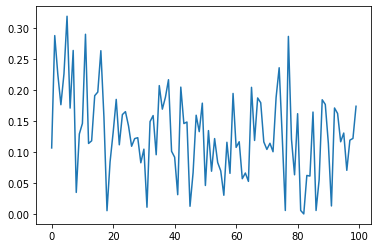

In [288]:
plt.plot(loss_sgd)

In [328]:
acc = []
for i in range(10):
    # load data 
    dataset = data.TensorDataset(data_tr,targets_tr) # create your datset
    dataloader = data.DataLoader(dataset, batch_size=25, shuffle=True) # create your dataloader
    # adam
    w = torch.randn(1, 4, requires_grad=True)
    b = torch.randn(1, requires_grad=True)

    opt_sgd = optim.Adam([w,b], lr=0.01, weight_decay=0.0001)
    epochs = 100

    loss_sgd = []

    for epoch in range(epochs):
        for batch in dataloader:
            opt_sgd.zero_grad()
            output = svm(batch[0], w, b)
            loss = hinge_loss(output,batch[1])
            loss.backward()
            opt_sgd.step()
        output = svm(batch[0], w, b)
        loss_sgd.append(hinge_loss(output,batch[1]).data)

    prediction_va =  torch.sigmoid(svm(data_va, w, b))
    accuracy_adam = accuracy(prediction_va,targets_va)
#     print("ADAM validation set accuracy: ",accuracy_adam)
    acc.append(accuracy_adam)

print(sum(acc)/len(acc))

0.8920000000000001


In [322]:
prediction_tr =  torch.sigmoid(svm(data_tr, w, b))
accuracy_adam = accuracy(prediction_tr,targets_tr)
print("ADAM training set accuracy: ",accuracy_adam)


prediction_va =  torch.sigmoid(svm(data_va, w, b))
accuracy_adam = accuracy(prediction_va,targets_va)
print("ADAM validation set accuracy: ",accuracy_adam)

ADAM training set accuracy:  0.9733333333333334
ADAM validation set accuracy:  0.96


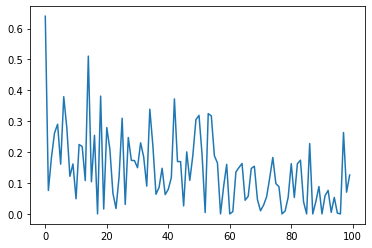

In [285]:
plt.plot(loss_sgd)